# Detecting and analyzing news events

Damian Trilling and Marieke van Hoof


This Notebook contains the analysis of the similarity files created with the INCA-functions to calculate cosine and soft-cosine similarities.

In [1]:
import os
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import infomap
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.externals import joblib
from utilities import most_distinguishing_words
from string import punctuation
punctuation = punctuation+"‘–"
from nltk import ngrams
import requests
stopword_list = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-nl/master/stopwords-nl.txt").text.splitlines()
%matplotlib inline

## Load/specify datasets

We need to load three datasets:

1. Nodes and edges for the softcosine-dataset
2. As a baseline for comparisons: nodes and edges for the traditional cosine dataset
3. The articles themselves (titles, texts, ...) to join with the first two datasets

In [2]:
softcosinefiles = glob('../../data/intermediate/softcosine/*.net')
cosinefiles = glob('../../data/intermediate/cosine/*.net')

print('There are {} softcosine and {} cosine files.'.format(len(softcosinefiles), len(cosinefiles)))

There are 149 softcosine and 149 cosine files.


In [3]:
# There are essentially two ways of going about combining all our files
# Either we merge them first and create ONE graph that we partition later,
# or we partition each file's graph seperately.
# The theoretical implication is that in the first scenario, the three-day
# moving window can be stretched (as something on the last day of a window
# can also be similar to sth in the 'new' window), in the latter scenario,
# that's not possible. 
# Empirical tests show that this stretching can lead to a drift over time,
# with large partitions that extend to multiple events. 
# However, this problem only emerges when using an unsuitable clustering
# algorithm, in particular modularity (instead of surprise)

def merge_pajekfiles(files, outputfile):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.node[node]['id']
            del H.node[node]['x']
            del H.node[node]['y']
            del H.node[node]['shape']
        G.update(H)
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    print('Removing self loops...')
    G.remove_edges_from(list(G.selfloop_edges()))
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    nx.write_pajek(G, outputfile)
    print('All written to {}'.format(outputfile))
    return G
Gnxsoft = merge_pajekfiles(softcosinefiles, '../../data/intermediate/softcosine_merged.net')
Gnxcos = merge_pajekfiles(cosinefiles, '../../data/intermediate/cosine_merged.net')
Gsoft = ig.read('../../data/intermediate/softcosine_merged.net', format='pajek')
Gcos = ig.read('../../data/intermediate/cosine_merged.net', format='pajek')


100%|██████████| 149/149 [02:45<00:00,  1.22it/s]


45608 nodes and 935592 edges
Removing self loops...
45608 nodes and 890597 edges


  0%|          | 0/149 [00:00<?, ?it/s]

All written to ../../data/intermediate/softcosine_merged.net


100%|██████████| 149/149 [00:36<00:00,  4.95it/s]


45213 nodes and 109336 edges
Removing self loops...
45213 nodes and 64341 edges
All written to ../../data/intermediate/cosine_merged.net


In [4]:
with open('../../data/raw-private/articles/articles_as_json-lines.json', mode='r') as f:
    articles = pd.DataFrame((json.loads(l) for l in f))
print(articles.keys())
print('{} articles in total'.format(len(articles)))

Index(['_id', 'byline', 'category', 'doctype', 'feedurl', 'images',
       'paywall_na', 'publication_date', 'softcosine_processed', 'teaser',
       'teaser_rss', 'text', 'title', 'title_rss', 'url'],
      dtype='object')
45609 articles in total


## Define functions
Here, we define functions to transform the files to a graph, partition the graph, analyze it, etc.

In [5]:
def partition_graph(G0, minedgeweight):
    '''takes an igraph, prunes it and particions it. returns a list of partitions '''
    G = G0.copy()
    G.es.select(weight_le=minedgeweight).delete()
    # part = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    # print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [6]:
def show_descriptives(results, filename=None):
    '''takes a list of lists (articles per event), plots a histogram and prints descriptives'''
    articles_per_event = [len(x) for x in results]
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

In [7]:
def print_gridreport(gridresults):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]

        print('Found {} articles, out of which {} are unique articles'.format(len(flattened), len(set(flattened))))
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple events)')
    print('\n\n')

    for r in gridresults:
        print("*"*80)
        print('Similarity metric: {}\n Minimum edgeweight: {}\n'.format(r['similarity'], r['minedgeweight']))
        print("*"*80)
        show_descriptives(r['results'], filename = '../../report/figures/{}{}'.format(r['similarity'], r['minedgeweight']))
        print('\n\n\n')

## Conduct clustering

We now conduct the clustering. We use a grid in which we vary the similarity calculation (cosine vs softcosine) and the minimum edgeweight threshold (.2, .3, .4, .5, .6)

In [8]:
grid = [('cos', Gcos, .2),
        ('cos', Gcos, .3),
        ('cos', Gcos, .4),
        ('cos', Gcos, .5),
        ('cos', Gcos, .6),
        ('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .5),
        ('softcos', Gsoft, .6)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in tqdm(grid)]



100%|██████████| 10/10 [01:19<00:00,  8.04s/it]


Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


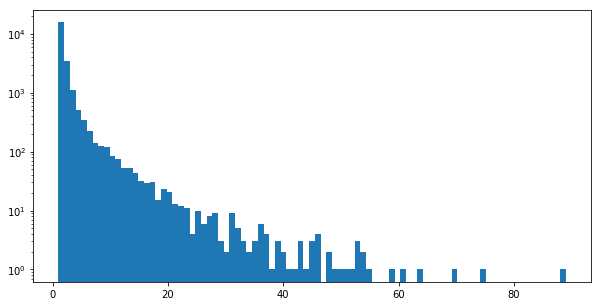

count    22372.000000
mean         2.020964
std          3.443622
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         89.000000
dtype: float64

There are 15685 single-article events and 6687 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


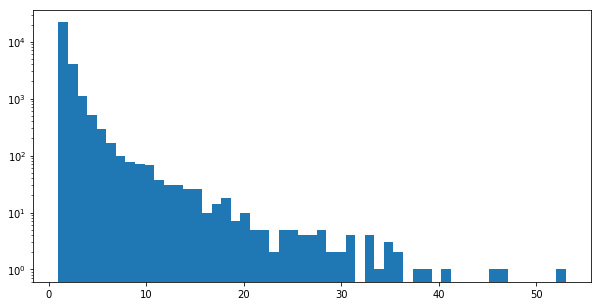

count    28614.000000
mean         1.580101
std          2.019407
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         53.000000
dtype: float64

There are 21842 single-article events and 6772 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


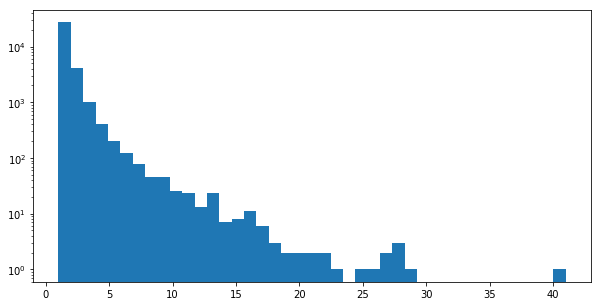

count    33374.000000
mean         1.354737
std          1.220428
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

There are 27136 single-article events and 6238 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.5

********************************************************************************


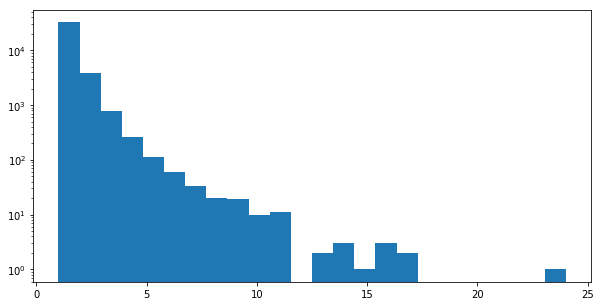

count    37398.000000
mean         1.208968
std          0.713758
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
dtype: float64

There are 32232 single-article events and 5166 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.6

********************************************************************************


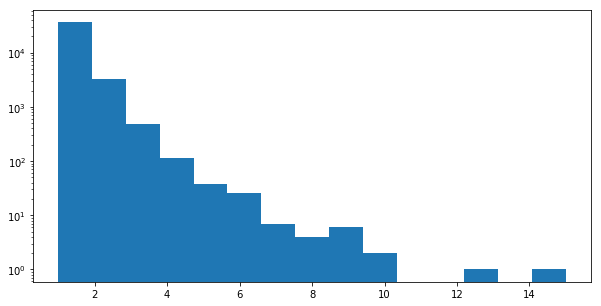

count    40247.000000
mean         1.123388
std          0.449985
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36348 single-article events and 3899 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


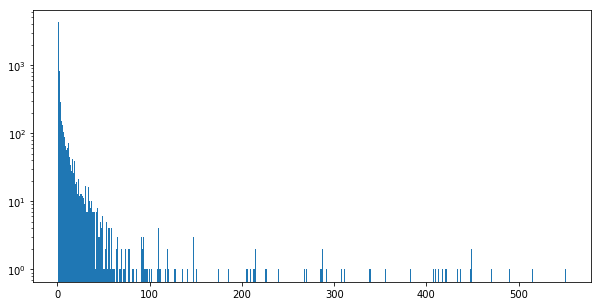

count    6739.000000
mean        6.767770
std        29.327142
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       551.000000
dtype: float64

There are 4233 single-article events and 2506 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


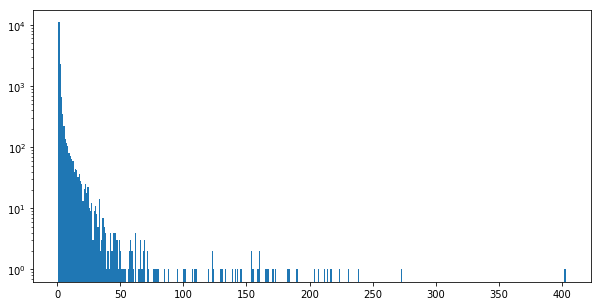

count    15719.000000
mean         2.901457
std         10.391014
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        403.000000
dtype: float64

There are 11018 single-article events and 4701 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


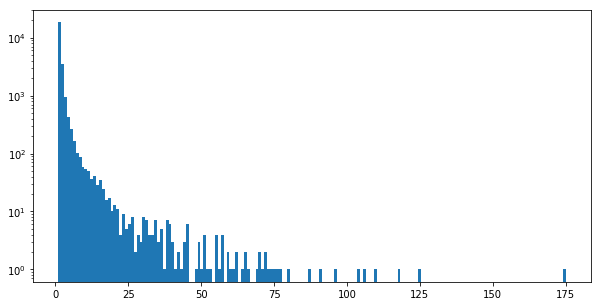

count    24276.000000
mean         1.878728
std          4.316295
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        175.000000
dtype: float64

There are 18307 single-article events and 5969 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.5

********************************************************************************


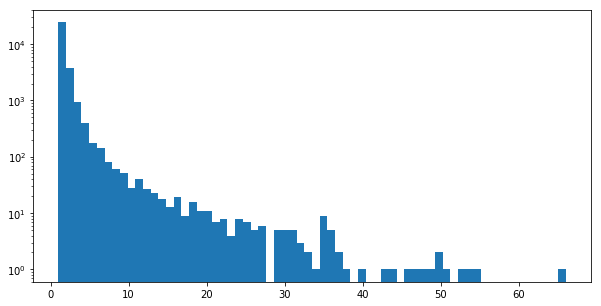

count    30320.000000
mean         1.504222
std          2.244801
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         66.000000
dtype: float64

There are 24372 single-article events and 5948 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.6

********************************************************************************


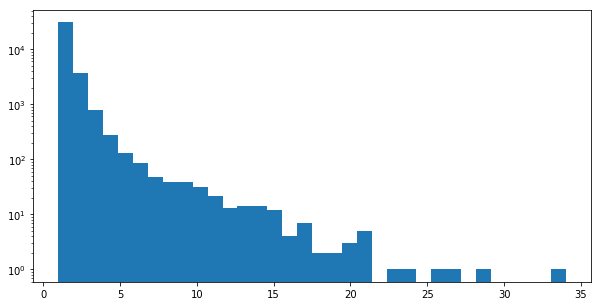

count    35964.000000
mean         1.268157
std          1.070803
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         34.000000
dtype: float64

There are 30707 single-article events and 5257 multiple-article events.






In [9]:
print_gridreport(gridresults)

## Evaluation of the results

check how much sense it makes etc

In [10]:
def merge_results_with_articles(results):
    results_merged = [[articles.query('_id=="{}"'.format(art)) for art in event] for event in results]
    df = pd.DataFrame(results_merged)
    return df

def _getfield(x, field):
    try:
        return x[field].to_list()[0]
    except:
        return None
def reduce_to_field(merged_df, field):
    return merged_df.applymap(lambda x: _getfield(x, field))

In [11]:
df_cos04 = merge_results_with_articles(gridresults[2]['results'])
df_cos05 = merge_results_with_articles(gridresults[3]['results'])
df_cos06 = merge_results_with_articles(gridresults[4]['results'])
df_softcos04 = merge_results_with_articles(gridresults[7]['results'])
df_softcos05 = merge_results_with_articles(gridresults[8]['results'])
df_softcos06 = merge_results_with_articles(gridresults[9]['results'])

### Manual evaluation of method
To evaluate the cosine and softcosine simiarlity methods on precision, we manually inspect a random sample of 100 multiple-article news events for minedgeweight=0.4, 0.5 and 0.6. Precision is defined as the number of articles  in the cluster that relate to the news event relative to the total number of articles in the cluster. The files can be found in ../../data/evaluation.

#### Create random samples

In [12]:
outdir = '../../data/evaluation'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [13]:
df_list = [df_cos04, df_cos05, df_cos06, df_softcos04, df_softcos05, df_softcos06]
names = ['cos04', 'cos05', 'cos06', 'softcos04', 'softcos05', 'softcos06']

In [14]:
i = 101
for name, data in zip(names, df_list):
    df = reduce_to_field(data, 'title')
    n_articles = df.count(axis=1)
    df = df.join(n_articles.rename('n_articles'))
    df = df.loc[df.n_articles > 1] # reducde to multi-article news events
    df.replace(',' '', inplace=True)
    df = df.sample(n=100, random_state=i)
    filename = '{name}_EMPTY.csv'.format(name=name)
    df.to_csv(os.path.join(outdir, filename), sep=',')
    print('Random sample for', name, 'with random_state =', i, 'saved as ../../data/evaluation/{name}_EMPTY.csv'.format(name=name))
    i += 1

Random sample for cos04 with random_state = 101 saved as ../../data/evaluation/cos04_EMPTY.csv
Random sample for cos05 with random_state = 102 saved as ../../data/evaluation/cos05_EMPTY.csv
Random sample for cos06 with random_state = 103 saved as ../../data/evaluation/cos06_EMPTY.csv
Random sample for softcos04 with random_state = 104 saved as ../../data/evaluation/softcos04_EMPTY.csv
Random sample for softcos05 with random_state = 105 saved as ../../data/evaluation/softcos05_EMPTY.csv
Random sample for softcos06 with random_state = 106 saved as ../../data/evaluation/softcos06_EMPTY.csv


#### Calculate precision

Precision is presented in three ways:
 - __Prec. 1:__ Percentage of news events that are entirely correct.
 - __Prec. 2:__ Percentage of news articles that relate to the news events correctly.
 - __TP/max. TP:__ True Positives out of the maximum True Postives.

In [15]:
eval_list = []
for name in names:
    eval_list.append(pd.read_csv('../../data/evaluation/{}_DONE.csv'.format(name), sep=';'))

In [16]:
def calculate_precision(df):
    df['precision'] = np.where(df.n_articles == df.n_correct, 1, 0)
    score_opt1 = (df['precision'].value_counts()[1] / len(df)) * 100
    df['proportion_correct'] = (df.n_correct / df.n_articles) * 100
    score_opt2 = df.proportion_correct.mean()
    score_opt3 = sum(df.n_correct)
    total_articles = sum(df.n_articles)
    print('Perc. 1:', score_opt1, '\nPrec. 2:', score_opt2, '\nTP/max. TP:', score_opt3, '/', total_articles)

In [17]:
precision_df = pd.DataFrame()
for name, df in zip(names, eval_list):
    print('Results for...', name)
    calculate_precision(df)

Results for... cos04
Perc. 1: 74.0 
Prec. 2: 88.51709401709401 
TP/max. TP: 223 / 268
Results for... cos05
Perc. 1: 78.0 
Prec. 2: 89.01666666666667 
TP/max. TP: 217 / 253
Results for... cos06
Perc. 1: 89.0 
Prec. 2: 94.38690476190476 
TP/max. TP: 204 / 225
Results for... softcos04
Perc. 1: 56.00000000000001 
Prec. 2: 76.2042970917971 
TP/max. TP: 234 / 521
Results for... softcos05
Perc. 1: 65.0 
Prec. 2: 81.7704939668175 
TP/max. TP: 236 / 379
Results for... softcos06
Perc. 1: 75.0 
Prec. 2: 86.91932234432235 
TP/max. TP: 222 / 289


### RQ1

In [18]:
def get_venn_from_outlets(outlet_df, filename=None):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    events_ad = set(dichotomized[dichotomized['ad (www)']==True].index)
    events_vk = set(dichotomized[dichotomized['volkskrant (www)']==True].index)
    events_nu = set(dichotomized[dichotomized['nu']==True].index)
    fig = plt.figure(figsize=(10,10))
    venn3([events_ad, events_vk, events_nu], set_labels = ['AD', 'Volkskrant', 'nu'])
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()

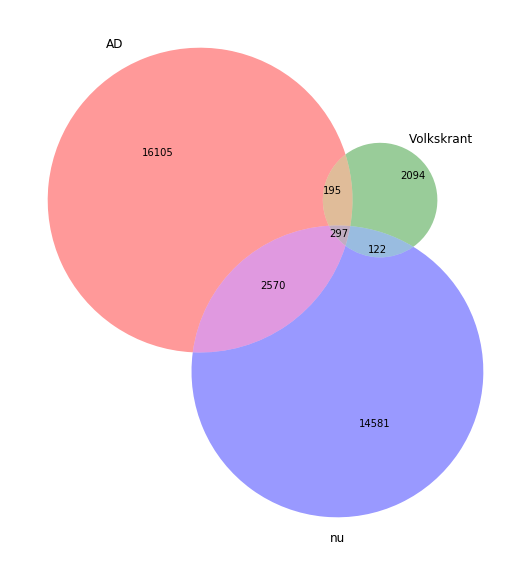

In [19]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
get_venn_from_outlets(df_softcos06_outlet, '../../report/figures/vennsoft06')

### RQ2

To compare the content of fully covered news events with AD-only, Volkskrant-only and nu.nl-only news events, we apply an automated method that classifies Dutch news items into four news categories: Politics, Business, Entertainment and Other ([Vermeer, 2018](https://figshare.com/articles/A_supervised_machine_learning_method_to_classify_Dutch-language_news_items/7314896/1)).

In [20]:
def get_fully_covered_events(outlet_df):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    
    events_fullycovered = set(dichotomized[dichotomized.sum(axis=1)==3].index)
    ad_only = set(dichotomized[(dichotomized['ad (www)'] == 1) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 0)].index)
    vk_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 1)].index)
    nu_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 1) & (dichotomized['volkskrant (www)'] == 0)].index)
    
    groups = (events_fullycovered, ad_only, vk_only, nu_only)
    
    return groups

def get_topics(text_df, path_to_model):
    clf = joblib.load(path_to_model)
    i=0
    all_text = text_df.values.tolist()
    no_none = []
    for l in all_text:
        for text in l:
            if text == None:
                i+=1
            elif text != None:
                # make lowercase and remove punctuation and stopwords.
                text = text.lower().translate(str.maketrans('', '', punctuation)).split()
                filtered_text = []
                for word in text:
                    if word not in stopword_list:
                        filtered_text.append(word)
                no_none.append(" ".join(filtered_text))
    
    topic = clf.predict([e for e in no_none])
    unique, counts = np.unique(topic, return_counts=True)
    result = dict(zip(unique, counts/len(topic)*100))
    
    return result

def topic_graph(topics):
    labels = ['Fully covered', 'AD only', 'VK only', 'nu.nl only']
    barWidth = 0.23

    plt.figure(figsize=(10,5))

    r1 = np.arange(len(topics['Business']))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, topics['Business'], width=barWidth, label='Business')
    plt.bar(r2, topics['Entertainment'], width=barWidth, label='Entertainment')
    plt.bar(r3, topics['Politics'], width=barWidth, label='Politics')
    plt.bar(r4, topics['Other'], width=barWidth, label='Other')

    plt.xlabel('')
    plt.xticks([r + barWidth for r in range(len(topic_fully))], labels)

    plt.legend()
    filename = '../../report/figures/classification'
    plt.savefig(filename+'.png', dpi=400)
    plt.savefig(filename+'.eps')
    plt.show()

In [21]:
# Download classifier by Vermeer (2018) if we don't have it yet

PATH_TO_MODEL = '../lib/PassiveAggressive_text_Dutch_news.pkl'

if not os.path.exists(PATH_TO_MODEL):
    r = requests.get('https://ndownloader.figshare.com/files/13514468', allow_redirects=True)
    with open(PATH_TO_MODEL, mode = 'wb') as f:
        f.write(r.content)
    print('Downloaded classifier with status code {} and saved as {}'.format(r.status_code, PATH_TO_MODEL))

In [22]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
groups = get_fully_covered_events(df_softcos06_outlet)

In [23]:
df_softcos06_text = reduce_to_field(df_softcos06, 'text')

In [24]:
fully_text = df_softcos06_text.iloc[list(groups[0])]
ad_text = df_softcos06_text.iloc[list(groups[1])]
vk_text = df_softcos06_text.iloc[list(groups[2])]
nu_text = df_softcos06_text.iloc[list(groups[3])]

In [25]:
topic_fully = get_topics(fully_text, PATH_TO_MODEL)
topic_ad = get_topics(ad_text, PATH_TO_MODEL)
topic_vk = get_topics(vk_text, PATH_TO_MODEL)
topic_nu = get_topics(nu_text, PATH_TO_MODEL)

In [26]:
topics = pd.DataFrame([topic_fully, topic_ad, topic_vk, topic_nu])
topics

,Business,Entertainment,N/A,Other,Politics
0,18.820225,40.955056,NaN,9.157303,31.067416
1,12.310165,78.921406,0.016628,2.361157,6.390644
2,22.222222,37.348273,0.046685,3.501401,36.881419
3,18.505245,71.577507,0.032580,3.277514,6.607154


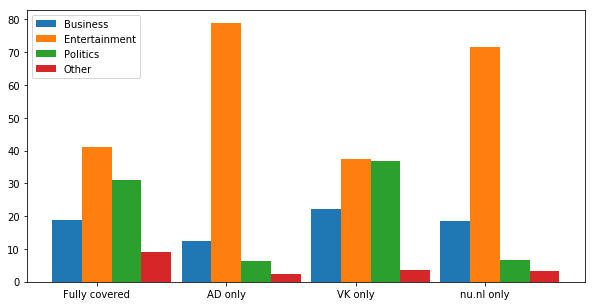

In [27]:
topic_graph(topics=topics)

In [28]:
def column_to_words(df, bigrams = True):
    '''we are only considering the first article; we only want one per event b/c we 
    are interested in the events not the articles'''
    longstring = df[0].str.cat()
    longstring = longstring.translate(str.maketrans('', '', punctuation))
    tokens = [w.lower() for w in longstring.split()]
    filtered_tokens=[]
    for word in tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    if bigrams:
        filtered_tokens.extend(["_".join(tup).lower() for tup in ngrams(longstring.split(),2)])
    
    return tokens

### ad vs fully covered
it's sports

In [29]:
md_ad = most_distinguishing_words(column_to_words(ad_text), column_to_words(fully_text), top = 20)
md_ad

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,134.499709,je,19069,18815.20122888035,330,583.7987711196496
1,106.853295,seizoen,2038,1978.607686319703,2,61.39231368029719
2,79.756212,haar,9639,9501.196517248925,157,294.80348275107417
3,72.278649,auto,2044,1991.216460791348,9,61.78353920865203
4,67.945378,ze,18974,18789.013774208473,398,582.986225791528
5,61.907265,finale,1013,982.5145030597348,0,30.48549694026522
6,51.003116,fc,978,949.5377082877397,1,29.46229171226027
7,48.649315,won,1133,1101.8129076760697,3,34.1870923239302
8,47.001385,wedstrijd,1340,1305.4931106795686,6,40.506889320431384
9,45.877474,club,1459,1422.8517038387274,8,44.14829616127254


In [30]:
with open('../../report/table_appendix_loglikelihood_ad.tex', mode='w') as f:
    f.write(md_ad.to_latex())

### nu vs fully covered
it's sports and entertainment and crime

In [31]:
md_nu = most_distinguishing_words(column_to_words(nu_text), column_to_words(fully_text), top = 20)
md_nu

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,105.469117,seizoen,1797,1738.4198961630418,2,60.58010383695818
1,95.850477,politie,5591,5474.2349704078,74,190.76502959220016
2,86.029898,auto,2055,1994.4962010453132,9,69.50379895468687
3,84.392332,je,15195,15002.206163385894,330,522.7938366141055
4,73.185542,nunl,1397,1352.8559503214333,3,47.14404967856668
5,71.076834,uur,4724,4630.632652814506,68,161.36734718549394
6,58.328906,the,2459,2400.3529861417433,25,83.64701385825688
7,58.258636,aangehouden,1315,1275.5498960173513,5,44.450103982648585
8,53.032861,fc,903,873.5584136361255,1,30.441586363874485
9,51.180004,een,80623,80259.14557849783,2433,2796.854421502167


In [32]:
with open('../../report/table_appendix_loglikelihood_nu.tex', mode='w') as f:
    f.write(md_nu.to_latex())

### vk vs fully covered
it's politics!

In [33]:
md_vk = most_distinguishing_words(column_to_words(vk_text), column_to_words(fully_text), top = 20)
md_vk

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,79.883644,ze,8133,7934.441473313572,398,596.5585266864284
1,55.231884,zegt,3811,3699.8251296262324,167,278.1748703737677
2,53.704643,een,37595,37228.90907206607,2433,2799.09092793393
3,40.260198,maar,8552,8404.127670010717,484,631.8723299892823
4,36.573481,hier,1318,1266.7576235673525,44,95.24237643264746
5,28.078444,hun,3763,3682.1537677703,196,276.8462322296999
6,27.499340,haar,3125,3052.495242693136,157,229.50475730686415
7,27.279402,politieke,908,871.4771610004474,29,65.52283899955262
8,23.052683,is,20041,19865.400941097712,1318,1493.5990589022888
9,21.603100,hesjes,149,138.5806798175738,0,10.41932018242619


In [34]:
with open('../../report/table_appendix_loglikelihood_vk.tex', mode='w') as f:
    f.write(md_vk.to_latex())

# Compare with infomap

infomap was used by Nicholls2018. It does not require a threshold (they say)

In [35]:
def findCommunities(Gin, minedgeweight=None):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    
    G = Gin.copy()
    
    if minedgeweight:
        insignificant_edges = ([(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < minedgeweight])
        G.remove_edges_from(insignificant_edges)

    infomapWrapper = infomap.Infomap("--two-level --silent")  # even testen zonder two-level
    # infomapWrapper = infomap.Infomap(" --silent")
    
    network = infomapWrapper.network()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges(data=True):
        network.addLink(e[0],e[1],e[2]['weight'])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    #tree = network.tree

    # print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    print("Found {} modules with codelength: {}".format(infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    print("Result")
    print("\n#node module")
 
    communities = {}
    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            print("{} {}".format(node.physicalId, node.moduleIndex()))
    
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return G

In [36]:
Gnxint = nx.convert_node_labels_to_integers(Gnxcos)
H = findCommunities(Gnxint)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6631 modules with codelength: 3.982553912221564
Result

#node module
0 0
319 0
1 1
41043 1
2 2
2171 2
5239 2
9848 2
10702 2
12399 2
12519 2
14054 2
17209 2
25852 2
26008 2
26712 2
31409 2
36632 2
37535 2
37623 2
42813 2
45042 2
7417 2
41768 2
11500 2
33138 2
3 3
38770 3
4 4
18300 4
5 5
21174 5
7 6
362 6
949 6
3027 6
15176 6
18023 6
20205 6
20820 6
23454 6
23884 6
28039 6
28997 6
29281 6
29506 6
29968 6
30659 6
30764 6
32317 6
35403 6
36991 6
42331 6
769 6
2201 6
36211 6
6291 6
6457 6
27869 6
37934 6
6351 6
30450 6
33463 6
8 7
14044 7
18958 7
9 8
153 8
916 8
12466 8
12714 8
14157 8
29425 8
31921 8
37841 8
11 9
2451 9
9001 9
13680 9
14429 9
20663 9
24466 9
26276 9
29937 9
39377 9
4233 9
24348 9
25093 9
5009 9
14728 9
21965 9
36082 9
37560 9
40292 9
44573 9
13 10
26 10
7340 10
7649 10
14433 10
27859 10
30735 10
32897 10
40700 10
44398 10
276 10
11290 10
11926 10
12502 10
15155 10
22156 10
33349 10
366

1710 120
17244 120
18143 120
19874 120
31067 120
31364 120
38497 120
4252 120
9930 120
10949 120
13419 120
20398 120
28355 120
186 121
3184 121
9189 121
11175 121
11378 121
11745 121
14217 121
15293 121
17711 121
22177 121
25993 121
27029 121
27361 121
37433 121
37703 121
38150 121
42979 121
44739 121
207 121
1388 121
3905 121
4856 121
11945 121
13190 121
18549 121
21911 121
22931 121
22955 121
31292 121
31765 121
35059 121
44515 121
751 121
2679 121
5656 121
25519 121
33869 121
1671 121
17251 121
27153 121
4006 121
6848 121
9218 121
14954 121
25269 121
29181 121
31833 121
35704 121
18560 121
20488 121
22248 121
23160 121
38586 121
39290 121
41232 121
188 122
2995 122
10020 122
190 123
34317 123
38850 123
191 124
10991 124
195 125
2540 125
5374 125
14822 125
25708 125
197 126
21744 126
2453 126
3594 126
5501 126
8864 126
9284 126
13445 126
13457 126
16945 126
20689 126
23949 126
24997 126
26518 126
29788 126
31830 126
33594 126
34834 126
40590 126
40654 126
40808 126
42014 126
42243 12

32879 326
8949 326
33453 326
34558 326
508 327
12438 327
23035 327
510 328
3242 328
7032 328
23049 328
511 329
7119 329
15805 329
28545 329
29399 329
30552 329
13886 329
19554 329
36350 329
44520 329
512 330
29606 330
30852 330
42845 330
513 331
547 331
514 332
25674 332
29204 332
515 333
5026 333
17737 333
30885 333
5016 333
31226 333
43317 333
8722 333
28834 333
516 334
8481 334
520 335
22062 335
33365 335
35132 335
38555 335
8436 335
21173 335
22591 335
25444 335
32460 335
32931 335
37667 335
521 336
3393 336
5182 336
13755 336
15650 336
23374 336
27131 336
30866 336
522 337
7897 337
18342 337
43868 337
9929 337
20109 337
22483 337
26305 337
36955 337
37645 337
43279 337
523 338
5857 338
525 339
7592 339
8869 339
15422 339
34677 339
34787 339
526 340
20998 340
1692 340
3876 340
5470 340
19986 340
20748 340
26476 340
28793 340
30299 340
32975 340
10350 340
11854 340
27057 340
33705 340
527 341
15732 341
43665 341
528 342
1772 342
9892 342
15114 342
21984 342
22064 342
23778 342
25153

10125 477
21084 477
27739 477
33945 477
785 478
5302 478
17797 478
43974 478
789 479
31784 479
792 480
1768 480
2353 480
21000 480
26964 480
29434 480
30445 480
42103 480
793 481
4717 481
13058 481
41928 481
794 482
3586 482
4477 482
7097 482
7684 482
9314 482
9434 482
9888 482
12065 482
12748 482
14154 482
14561 482
14661 482
15045 482
15669 482
15929 482
16428 482
16903 482
17171 482
17611 482
17849 482
18751 482
19933 482
20129 482
21626 482
21741 482
23025 482
23691 482
23994 482
24011 482
25377 482
26821 482
27039 482
28217 482
31405 482
31658 482
33127 482
33822 482
35006 482
35284 482
35548 482
35866 482
40163 482
40866 482
41179 482
41211 482
41377 482
43987 482
44798 482
795 483
11166 483
13698 483
15536 483
19181 483
24773 483
31995 483
35248 483
2675 483
3024 483
7261 483
12206 483
17828 483
20137 483
30085 483
30768 483
34424 483
40897 483
43264 483
43753 483
797 484
4109 484
16044 484
23340 484
42822 484
801 485
16912 485
21515 485
40870 485
809 485
1548 485
5047 485
12616

34086 634
34709 634
36153 634
38226 634
44729 634
3437 634
20169 634
23624 634
27087 634
9294 634
10132 634
9705 634
17613 634
18838 634
1073 635
6370 635
1074 636
33823 636
40324 636
9959 636
24336 636
28314 636
29589 636
35299 636
40635 636
1076 637
3629 637
3943 637
7005 637
12570 637
12888 637
13594 637
15051 637
15869 637
16716 637
17012 637
17433 637
21567 637
23324 637
23377 637
23702 637
25672 637
28582 637
31634 637
32249 637
35792 637
35933 637
37123 637
38237 637
39526 637
39790 637
44338 637
1077 638
38296 638
1079 639
4339 639
5513 639
21544 639
29444 639
38238 639
38701 639
41946 639
1080 640
4423 640
6818 640
14180 640
36375 640
43639 640
1081 641
2510 641
3420 641
11486 641
12518 641
12889 641
13870 641
16950 641
23138 641
24568 641
27619 641
29708 641
31053 641
31955 641
32700 641
33236 641
40331 641
1204 641
1494 641
10411 641
10495 641
11480 641
11628 641
17519 641
20573 641
29495 641
30335 641
33596 641
34085 641
37649 641
38885 641
40395 641
43023 641
11459 641
209

16460 742
17724 742
23988 742
25837 742
27099 742
32485 742
34710 742
38712 742
39758 742
41739 742
43077 742
38593 742
39617 742
1299 743
8325 743
8688 743
28599 743
31811 743
40557 743
40803 743
1600 743
10809 743
14156 743
28364 743
32512 743
25374 743
30578 743
31600 743
32434 743
34273 743
40669 743
43218 743
1300 744
45153 744
1302 745
3249 745
3425 745
7800 745
10333 745
14009 745
15548 745
20800 745
22469 745
22862 745
24034 745
26544 745
29521 745
34254 745
34415 745
38875 745
39495 745
40388 745
44951 745
3161 745
39607 745
5096 745
7426 745
8601 745
9626 745
13471 745
16578 745
17182 745
26620 745
29388 745
31440 745
34642 745
37293 745
37865 745
38135 745
38194 745
38268 745
38564 745
40622 745
41199 745
42522 745
43096 745
44725 745
28151 745
41444 745
1304 746
5333 746
5832 746
9880 746
11589 746
13356 746
19722 746
21914 746
24386 746
26279 746
26352 746
28186 746
29396 746
32176 746
37249 746
38781 746
1306 747
7289 747
11925 747
34919 747
1307 748
17730 748
23042 748
2

17357 866
18337 866
21905 866
26240 866
32870 866
9456 866
17311 866
17862 866
20916 866
23332 866
25588 866
28561 866
31337 866
34969 866
38410 866
39381 866
40928 866
41532 866
12704 866
38900 866
14888 867
34034 867
1539 868
14449 868
15636 868
24410 868
25487 868
35670 868
42835 868
1540 869
12038 869
12692 869
14069 869
16529 869
18777 869
20324 869
25077 869
26480 869
26794 869
29759 869
30210 869
35155 869
37216 869
38978 869
1542 870
3621 870
1547 871
11301 871
1549 872
16867 872
18700 872
1552 873
11095 873
17309 873
19814 873
40592 873
41939 873
1554 874
3652 874
6072 874
26936 874
30291 874
44997 874
1556 875
11027 875
21036 875
1557 876
6850 876
36349 876
28399 876
29916 876
45068 876
1558 877
6229 877
13972 877
37410 877
40865 877
1585 877
17136 877
23877 877
41018 877
9508 877
20934 877
22558 877
28940 877
31989 877
33170 877
1561 878
2688 878
8932 878
25051 878
26263 878
41536 878
42267 878
43906 878
1562 879
3574 879
5270 879
18974 879
22044 879
1564 880
6575 880
3994 8

42570 1083
43121 1083
4778 1083
7178 1083
20284 1083
22957 1083
24339 1083
28916 1083
32156 1083
32825 1083
44351 1083
44568 1083
44802 1083
32132 1083
42544 1083
1968 1084
5366 1084
16653 1084
20237 1084
25355 1084
41119 1084
5203 1084
40167 1084
14737 1084
45019 1084
1973 1085
5584 1085
19802 1085
39330 1085
44283 1085
1974 1086
5439 1086
25874 1086
27677 1086
35600 1086
1976 1087
10819 1087
1977 1088
13890 1088
41433 1088
1978 1089
3078 1089
9505 1089
27025 1089
35437 1089
36650 1089
37091 1089
39107 1089
1981 1090
3177 1090
3687 1090
4417 1090
4623 1090
5119 1090
5924 1090
10722 1090
12968 1090
16678 1090
19918 1090
23394 1090
23707 1090
25210 1090
25580 1090
26308 1090
26332 1090
26777 1090
26954 1090
28400 1090
29433 1090
29927 1090
30474 1090
31539 1090
34716 1090
36582 1090
37406 1090
37575 1090
38283 1090
39167 1090
40198 1090
41135 1090
41347 1090
41893 1090
42680 1090
42808 1090
43479 1090
44006 1090
44397 1090
3158 1090
6308 1090
3957 1090
4383 1090
4715 1090
8090 1090
1010

27660 1279
28815 1279
2402 1280
8792 1280
32708 1280
2404 1281
11381 1281
11734 1281
32592 1281
41789 1281
2405 1282
17398 1282
34157 1282
4656 1282
30423 1282
38746 1282
45150 1282
2407 1283
4210 1283
4471 1283
9678 1283
17707 1283
22284 1283
28396 1283
44678 1283
2408 1284
10142 1284
25551 1284
2410 1285
11526 1285
11653 1285
16442 1285
22703 1285
2411 1286
3658 1286
11597 1286
22499 1286
23686 1286
26090 1286
2681 1286
8920 1286
12441 1286
16112 1286
19296 1286
27010 1286
31365 1286
35405 1286
40620 1286
2412 1287
5534 1287
7128 1287
9878 1287
24136 1287
27904 1287
37762 1287
2415 1288
3349 1288
29398 1288
32643 1288
36118 1288
30470 1288
31155 1288
33455 1288
34579 1288
34617 1288
35910 1288
41583 1288
2416 1289
3564 1289
2417 1290
18980 1290
30545 1290
2418 1291
2670 1291
2947 1291
7373 1291
11617 1291
15558 1291
19661 1291
23541 1291
30034 1291
2419 1292
30847 1292
2423 1293
2538 1293
4344 1293
5017 1293
8313 1293
12946 1293
26214 1293
32826 1293
33260 1293
43651 1293
2425 1294
4

15531 1417
20509 1417
20621 1417
21765 1417
23525 1417
24117 1417
25008 1417
27578 1417
28340 1417
29413 1417
30804 1417
31066 1417
31441 1417
32661 1417
37930 1417
39706 1417
40589 1417
29437 1417
33057 1417
2750 1418
24444 1418
2751 1419
11384 1419
36762 1419
9151 1419
44918 1419
2753 1420
7060 1420
10974 1420
14127 1420
14881 1420
18965 1420
22800 1420
24813 1420
25307 1420
27958 1420
34913 1420
37290 1420
37540 1420
41507 1420
18912 1420
29330 1420
30181 1420
31093 1420
40027 1420
41622 1420
2754 1421
38427 1421
2755 1422
15078 1422
21648 1422
44823 1422
2758 1423
33873 1423
2760 1424
44368 1424
2763 1425
40782 1425
41569 1425
2764 1426
5030 1426
39300 1426
26448 1426
41150 1426
2766 1427
9893 1427
2770 1428
16587 1428
2777 1429
31051 1429
2778 1430
12557 1430
28483 1430
38279 1430
41440 1430
2779 1431
5255 1431
8278 1431
9984 1431
12304 1431
18779 1431
20604 1431
22507 1431
26481 1431
26660 1431
27330 1431
28902 1431
29528 1431
30718 1431
31522 1431
32688 1431
32913 1431
33598 143

5083 1634
19178 1634
20954 1634
22906 1634
24960 1634
15372 1634
15458 1634
24433 1634
3273 1635
11692 1635
12338 1635
38510 1635
4481 1635
12331 1635
15030 1635
17160 1635
22567 1635
28943 1635
33180 1635
43337 1635
3278 1636
8211 1636
33529 1636
6631 1636
16924 1636
23479 1636
25533 1636
31931 1636
3285 1637
15539 1637
16742 1637
18320 1637
20106 1637
22445 1637
24760 1637
24881 1637
31751 1637
32827 1637
32973 1637
33842 1637
40016 1637
3288 1638
7487 1638
16208 1638
28295 1638
36020 1638
3289 1639
7558 1639
13752 1639
15734 1639
15792 1639
17322 1639
18908 1639
18924 1639
20682 1639
20923 1639
22271 1639
23099 1639
26672 1639
27873 1639
31934 1639
32492 1639
33178 1639
37595 1639
39071 1639
40625 1639
40880 1639
3290 1640
10947 1640
12821 1640
17934 1640
33248 1640
40129 1640
3291 1641
26618 1641
35763 1641
38495 1641
3297 1642
6891 1642
8541 1642
3298 1643
16715 1643
18377 1643
21849 1643
27363 1643
27626 1643
34066 1643
3300 1644
4432 1644
6437 1644
13927 1644
22598 1644
32320 16

4090 1937
14410 1937
31444 1937
35232 1937
40023 1937
43795 1937
4091 1938
13413 1938
15584 1938
32283 1938
4095 1939
33696 1939
36147 1939
38203 1939
4096 1940
10689 1940
4100 1941
44445 1941
4101 1942
4512 1942
4102 1943
31129 1943
36778 1943
4105 1944
13850 1944
16286 1944
4111 1945
15893 1945
4114 1946
4219 1946
6716 1946
24327 1946
26431 1946
27145 1946
4115 1947
10169 1947
35861 1947
38735 1947
41932 1947
4117 1948
34046 1948
4128 1949
25782 1949
4136 1950
14943 1950
34789 1950
4139 1951
6502 1951
4142 1952
29820 1952
34474 1952
36577 1952
42758 1952
4143 1953
35960 1953
40857 1953
42961 1953
4144 1954
6847 1954
25187 1954
26283 1954
31320 1954
34072 1954
37348 1954
37596 1954
38010 1954
39316 1954
40543 1954
4407 1954
6211 1954
13676 1954
16329 1954
29681 1954
32445 1954
16081 1954
34683 1954
4148 1955
8199 1955
15611 1955
24131 1955
30312 1955
33567 1955
4149 1956
21406 1956
4150 1957
20817 1957
22547 1957
42730 1957
4154 1958
23080 1958
4156 1959
20700 1959
4158 1960
6390 1960

5036 2259
19615 2259
25433 2259
31884 2259
40796 2259
5042 2260
10446 2260
13382 2260
16458 2260
21582 2260
23737 2260
26902 2260
39365 2260
41513 2260
42616 2260
5043 2261
32074 2261
44599 2261
5048 2262
14615 2262
16472 2262
5050 2263
22726 2263
5051 2264
33834 2264
5053 2265
9247 2265
10381 2265
14293 2265
16359 2265
27759 2265
44313 2265
21188 2265
22559 2265
39361 2265
5055 2266
6250 2266
14292 2266
33909 2266
5057 2267
6193 2267
33577 2267
5061 2268
22577 2268
25178 2268
29157 2268
5062 2269
21570 2269
5063 2270
28120 2270
5068 2271
44811 2271
5072 2272
5419 2272
5076 2273
10874 2273
14573 2273
17083 2273
24358 2273
24680 2273
30286 2273
33081 2273
35075 2273
37243 2273
39832 2273
10309 2273
37665 2273
37871 2273
38813 2273
5080 2274
17071 2274
20712 2274
20790 2274
23021 2274
24962 2274
25088 2274
25834 2274
27570 2274
27988 2274
35688 2274
36092 2274
37155 2274
39069 2274
42269 2274
15643 2274
19525 2274
19663 2274
19843 2274
24740 2274
30043 2274
30525 2274
34757 2274
34846 22

42261 2503
5846 2504
7597 2504
14014 2504
14114 2504
14569 2504
16517 2504
16708 2504
18338 2504
24153 2504
30340 2504
31141 2504
32354 2504
36314 2504
37701 2504
42731 2504
5847 2505
21415 2505
5853 2506
20606 2506
37663 2506
14686 2506
14853 2506
31019 2506
5855 2507
40239 2507
5860 2508
41533 2508
41833 2508
45060 2508
5861 2509
22884 2509
5862 2510
42881 2510
5864 2511
7477 2511
12088 2511
17889 2511
21236 2511
40750 2511
41653 2511
5866 2512
9072 2512
25973 2512
5867 2513
37301 2513
5869 2514
30124 2514
36701 2514
37156 2514
41742 2514
44963 2514
10956 2514
15242 2514
27546 2514
36766 2514
41746 2514
5873 2515
21715 2515
45148 2515
5874 2516
32660 2516
5884 2517
29216 2517
5886 2518
10060 2518
32657 2518
38303 2518
38934 2518
41455 2518
10958 2518
18937 2518
23760 2518
25667 2518
5888 2519
13007 2519
16952 2519
23511 2519
28379 2519
28745 2519
44524 2519
16806 2519
43981 2519
5895 2520
38988 2520
5897 2521
38041 2521
5898 2522
37856 2522
5899 2523
13056 2523
13331 2523
18701 2523


37141 2806
6856 2807
27848 2807
38045 2807
27478 2807
34295 2807
6858 2808
23051 2808
42737 2808
43466 2808
40801 2808
42630 2808
6865 2809
11502 2809
22476 2809
28847 2809
30035 2809
43960 2809
6869 2810
33665 2810
6871 2811
44259 2811
6872 2812
14209 2812
39688 2812
40578 2812
6892 2813
31637 2813
6895 2814
25760 2814
6899 2815
43384 2815
43735 2815
6900 2816
44190 2816
6901 2817
7389 2817
16700 2817
40487 2817
40695 2817
6902 2818
9360 2818
6908 2819
7258 2819
11200 2819
22908 2819
25628 2819
34965 2819
39594 2819
9684 2819
9885 2819
16638 2819
6916 2820
15159 2820
6917 2821
27249 2821
6919 2822
24820 2822
6922 2823
19599 2823
35894 2823
6924 2824
7736 2824
6928 2825
22807 2825
6930 2826
24570 2826
6932 2827
7260 2827
32326 2827
6933 2828
7568 2828
13732 2828
21890 2828
25473 2828
6942 2829
27633 2829
6943 2830
27336 2830
6951 2831
41411 2831
6953 2832
38188 2832
6957 2833
19936 2833
6962 2834
9732 2834
17283 2834
22814 2834
41371 2834
6967 2835
27500 2835
7517 2835
14191 2835
14482

40442 3204
8338 3205
40166 3205
8346 3206
27833 3206
41832 3206
19420 3206
26852 3206
30109 3206
36255 3206
8351 3207
42204 3207
8352 3208
26704 3208
8355 3209
17075 3209
39689 3209
8358 3210
33599 3210
8359 3211
21826 3211
24610 3211
8363 3212
22780 3212
8368 3213
25939 3213
8371 3214
34620 3214
8372 3215
19784 3215
8373 3216
23694 3216
8378 3217
8877 3217
8382 3218
25033 3218
8384 3219
17362 3219
19643 3219
28472 3219
29127 3219
8386 3220
37509 3220
8390 3221
11484 3221
13674 3221
24924 3221
28573 3221
8396 3222
18767 3222
41529 3222
8397 3223
10665 3223
18141 3223
20660 3223
40101 3223
40633 3223
12993 3223
20467 3223
22418 3223
44755 3223
15160 3223
15936 3223
37804 3223
19243 3223
36352 3223
24946 3223
25175 3223
29664 3223
8399 3224
10316 3224
20232 3224
23004 3224
29618 3224
36537 3224
36850 3224
38126 3224
38395 3224
12311 3224
28129 3224
30590 3224
43319 3224
8405 3225
31763 3225
8407 3226
12360 3226
16426 3226
17659 3226
20186 3226
39891 3226
40041 3226
43408 3226
8413 3227
3

21954 3653
42527 3653
10212 3654
23753 3654
10214 3655
11951 3655
10218 3656
15106 3656
16149 3656
21303 3656
33490 3656
10220 3657
17292 3657
41390 3657
41983 3657
10222 3658
12503 3658
16688 3658
39873 3658
14812 3658
18123 3658
38131 3658
10226 3659
37846 3659
10228 3660
15822 3660
31144 3660
10229 3661
23974 3661
10231 3662
21499 3662
31060 3662
10233 3663
10565 3663
10239 3664
38014 3664
44859 3664
10247 3665
33419 3665
33676 3665
34804 3665
40153 3665
10253 3666
36040 3666
10258 3667
12705 3667
10261 3668
11283 3668
10263 3669
14660 3669
27802 3669
10264 3670
23048 3670
39740 3670
10266 3671
21920 3671
33191 3671
18369 3671
25451 3671
42500 3671
10270 3672
35399 3672
10272 3673
25289 3673
10274 3674
43429 3674
10275 3675
18918 3675
25930 3675
10279 3676
17935 3676
10283 3677
10475 3677
17364 3677
19182 3677
39874 3677
10286 3678
28131 3678
10289 3679
29726 3679
10298 3680
31286 3680
42596 3680
10301 3681
29149 3681
10304 3682
16838 3682
26503 3682
43889 3682
10308 3683
13064 3683

40807 4153
12788 4154
15603 4154
12792 4155
19422 4155
12797 4156
44791 4156
12798 4157
25514 4157
28613 4157
12805 4158
26257 4158
12813 4159
18635 4159
34376 4159
35701 4159
19733 4159
31920 4159
12814 4160
34914 4160
12815 4161
39344 4161
41820 4161
12823 4162
40699 4162
12835 4163
19129 4163
12841 4164
34059 4164
12848 4165
38465 4165
40655 4165
12853 4166
18003 4166
23098 4166
31033 4166
35744 4166
12856 4167
34155 4167
36981 4167
12857 4168
30717 4168
12858 4169
14420 4169
12859 4170
14619 4170
12860 4171
23256 4171
23524 4171
12863 4172
42123 4172
12866 4173
42531 4173
12874 4174
21870 4174
24054 4174
29595 4174
12878 4175
17024 4175
22368 4175
12885 4176
15634 4176
12890 4177
17790 4177
21435 4177
12893 4178
26366 4178
44736 4178
12902 4179
22196 4179
23060 4179
12904 4180
38886 4180
12908 4181
16758 4181
12909 4182
29502 4182
12910 4183
41331 4183
12914 4184
14967 4184
12920 4185
16818 4185
19734 4185
20441 4185
26513 4185
28828 4185
31758 4185
35126 4185
35802 4185
37355 4185

42940 4715
16082 4716
23661 4716
16087 4717
17011 4717
25084 4717
27065 4717
31347 4717
34851 4717
16090 4718
32472 4718
16098 4719
38953 4719
16101 4720
23305 4720
23353 4720
36492 4720
16105 4721
21482 4721
31130 4721
34333 4721
44360 4721
16109 4722
40583 4722
16113 4723
35911 4723
16116 4724
37967 4724
16118 4725
35230 4725
16119 4726
21760 4726
16121 4727
16947 4727
16141 4728
16803 4728
28967 4728
16143 4729
38007 4729
44724 4729
16150 4730
23023 4730
16152 4731
16827 4731
16156 4732
41228 4732
16168 4733
16479 4733
16173 4734
40964 4734
16174 4735
43787 4735
16176 4736
32720 4736
16178 4737
32113 4737
16180 4738
16616 4738
23220 4738
31397 4738
16181 4739
33414 4739
16192 4740
23715 4740
36132 4740
16195 4741
18976 4741
41639 4741
16199 4742
18021 4742
16201 4743
18792 4743
23257 4743
41608 4743
42279 4743
43932 4743
16204 4744
17306 4744
28103 4744
28527 4744
36300 4744
36870 4744
30079 4744
39481 4744
40638 4744
16209 4745
30962 4745
35182 4745
41492 4745
43443 4745
16210 4746

30632 5171
19274 5172
21418 5172
19276 5173
32266 5173
19284 5174
25685 5174
19290 5175
21706 5175
40883 5175
44909 5175
19293 5176
39152 5176
19302 5177
41864 5177
19313 5178
29737 5178
19315 5179
35263 5179
37771 5179
38026 5179
19316 5180
40439 5180
19330 5181
25917 5181
27979 5181
19333 5182
21108 5182
22518 5182
22821 5182
29549 5182
34244 5182
19337 5183
22651 5183
19338 5184
22382 5184
27492 5184
41992 5184
19339 5185
27899 5185
33415 5185
33600 5185
23321 5185
36497 5185
30144 5185
34003 5185
19344 5186
40109 5186
19346 5187
19813 5187
27497 5187
28643 5187
19347 5188
26005 5188
19370 5189
39564 5189
19374 5190
23085 5190
19381 5191
30132 5191
37106 5191
44497 5191
19386 5192
32986 5192
19390 5193
35636 5193
19398 5194
36266 5194
36576 5194
19400 5195
19406 5195
23491 5195
31055 5195
19415 5196
30633 5196
32158 5196
40792 5196
19417 5197
19664 5197
32671 5197
19419 5198
25273 5198
19421 5199
33265 5199
19431 5200
21718 5200
19435 5201
31794 5201
19436 5202
32943 5202
19437 5203

25919 5843
29733 5843
33802 5843
35555 5843
37899 5843
25929 5844
42955 5844
25936 5845
26089 5845
35632 5845
25957 5846
33192 5846
25969 5847
38171 5847
25983 5848
29981 5848
25988 5849
27440 5849
25990 5850
31925 5850
26000 5851
33333 5851
26010 5852
43785 5852
26023 5853
30884 5853
31891 5853
26032 5854
28188 5854
37226 5854
26033 5855
39996 5855
26035 5856
32251 5856
26053 5857
30314 5857
26061 5858
30090 5858
33090 5858
34125 5858
38168 5858
26068 5859
36513 5859
30405 5859
31542 5859
40077 5859
26071 5860
30687 5860
33553 5860
39415 5860
43938 5860
30498 5860
44468 5860
26091 5861
29479 5861
34651 5861
36053 5861
37972 5861
26101 5862
29635 5862
26118 5863
42939 5863
44956 5863
26137 5864
36856 5864
26139 5865
34543 5865
26145 5866
39716 5866
26146 5867
37140 5867
26172 5868
44915 5868
26173 5869
28612 5869
26187 5870
31486 5870
31615 5870
26190 5871
44529 5871
26191 5872
42259 5872
26201 5873
33609 5873
26215 5874
31596 5874
31817 5874
26223 5875
40107 5875
26226 5876
39016 5876

31979 6286
44765 6286
31991 6287
41561 6287
32009 6288
33024 6288
32024 6289
41282 6289
42514 6289
32034 6290
42811 6290
32041 6291
33062 6291
32058 6292
45106 6292
32099 6293
37686 6293
32104 6294
38638 6294
39985 6294
40698 6294
32133 6295
36597 6295
32140 6296
34927 6296
32157 6297
39088 6297
32164 6298
41685 6298
32171 6299
34053 6299
32201 6300
39995 6300
32212 6301
36760 6301
32223 6302
34812 6302
32239 6303
43226 6303
32243 6304
38553 6304
41086 6304
32244 6305
32583 6305
32272 6306
38355 6306
32298 6307
37883 6307
32304 6308
44962 6308
32307 6309
38716 6309
32337 6310
42365 6310
32358 6311
38341 6311
32379 6312
32577 6312
32386 6313
35158 6313
39864 6313
32420 6314
39187 6314
32422 6315
36575 6315
38106 6315
43089 6315
32431 6316
43815 6316
32433 6317
42265 6317
32500 6318
43423 6318
32505 6319
38101 6319
32516 6320
37837 6320
32520 6321
33142 6321
32530 6322
39807 6322
32557 6323
36621 6323
42273 6323
32587 6324
35626 6324
36938 6324
32604 6325
39026 6325
42735 6325
32654 6326

In [37]:
Gnxsoftint = nx.convert_node_labels_to_integers(Gnxsoft)
Hsoft = findCommunities(Gnxsoftint)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 1777 modules with codelength: 10.058454686102687
Result

#node module
0 0
323 0
5979 0
6034 0
31813 0
1 1
47 1
54 1
202 1
270 1
344 1
354 1
391 1
407 1
443 1
612 1
636 1
836 1
974 1
1006 1
1019 1
1038 1
1305 1
1364 1
1390 1
1442 1
1471 1
1525 1
1531 1
1540 1
1550 1
1556 1
1559 1
1566 1
1574 1
1918 1
1988 1
2224 1
2253 1
2259 1
2281 1
2318 1
2369 1
2423 1
2469 1
2491 1
2571 1
2639 1
2716 1
2821 1
2871 1
3022 1
3043 1
3072 1
3201 1
3323 1
3335 1
3416 1
3593 1
3649 1
3656 1
3664 1
3733 1
3761 1
3819 1
3917 1
3999 1
4010 1
4091 1
4252 1
4261 1
4585 1
4604 1
4720 1
4830 1
4971 1
5056 1
5074 1
5123 1
5156 1
5205 1
5343 1
5368 1
5398 1
5420 1
5469 1
5475 1
5493 1
5688 1
5692 1
5701 1
5854 1
5947 1
5996 1
6004 1
6043 1
6117 1
6163 1
6480 1
6556 1
6712 1
6911 1
6948 1
7074 1
7205 1
7463 1
7496 1
7541 1
7710 1
7725 1
7875 1
7894 1
7913 1
7966 1
7980 1
8067 1
8088 1
8094 1
8183 1
8201 1
8332 1
8349 1
8353 1
8

34465 2
34536 2
34585 2
34639 2
34701 2
34702 2
34710 2
34781 2
34850 2
34891 2
34951 2
34953 2
34977 2
35014 2
35029 2
35031 2
35039 2
35102 2
35111 2
35124 2
35125 2
35229 2
35263 2
35337 2
35403 2
35471 2
35503 2
35510 2
35570 2
35601 2
35615 2
35627 2
35638 2
35644 2
35647 2
35669 2
35768 2
35775 2
35781 2
35789 2
35825 2
35853 2
35901 2
35905 2
35915 2
35919 2
35997 2
36117 2
36120 2
36133 2
36149 2
36189 2
36191 2
36195 2
36217 2
36388 2
36477 2
36478 2
36522 2
36541 2
36574 2
36602 2
36643 2
36739 2
36841 2
36886 2
36890 2
36895 2
36900 2
36940 2
36961 2
37060 2
37063 2
37079 2
37138 2
37204 2
37273 2
37281 2
37283 2
37307 2
37309 2
37354 2
37361 2
37373 2
37389 2
37501 2
37557 2
37590 2
37679 2
37682 2
37724 2
37803 2
37843 2
37888 2
37891 2
38009 2
38026 2
38071 2
38086 2
38105 2
38185 2
38207 2
38218 2
38289 2
38332 2
38381 2
38385 2
38386 2
38411 2
38469 2
38490 2
38522 2
38563 2
38686 2
38864 2
38898 2
39014 2
39070 2
39082 2
39099 2
39237 2
39262 2
39288 2
39310 2
39313 2


16427 10
16441 10
16482 10
16496 10
16532 10
16580 10
16604 10
16613 10
16638 10
16661 10
16729 10
16809 10
16841 10
16928 10
16939 10
17033 10
17051 10
17069 10
17089 10
17090 10
17109 10
17155 10
17251 10
17269 10
17434 10
17493 10
17556 10
17589 10
17611 10
17719 10
17738 10
17751 10
17767 10
17788 10
17938 10
17965 10
17969 10
17970 10
18038 10
18096 10
18116 10
18164 10
18217 10
18240 10
18310 10
18371 10
18401 10
18488 10
18552 10
18554 10
18562 10
18577 10
18597 10
18638 10
18696 10
18763 10
18778 10
18812 10
18817 10
18887 10
18922 10
18997 10
19062 10
19091 10
19161 10
19173 10
19218 10
19238 10
19239 10
19299 10
19332 10
19371 10
19401 10
19422 10
19431 10
19447 10
19474 10
19495 10
19513 10
19596 10
19607 10
19711 10
19742 10
19749 10
19763 10
19800 10
19825 10
19950 10
20040 10
20049 10
20106 10
20118 10
20246 10
20286 10
20358 10
20501 10
20535 10
20592 10
20618 10
20679 10
20697 10
20722 10
20727 10
20750 10
20800 10
20819 10
20829 10
20884 10
20925 10
21024 10
21110 10
2

40934 12
40936 12
41011 12
41180 12
41264 12
41286 12
41400 12
41419 12
41436 12
41441 12
41552 12
41710 12
41802 12
41872 12
41945 12
41966 12
42007 12
42039 12
42097 12
42113 12
42192 12
42240 12
42275 12
42282 12
42305 12
42310 12
42314 12
42316 12
42341 12
42368 12
42375 12
42387 12
42428 12
42456 12
42472 12
42493 12
42511 12
42726 12
42804 12
42839 12
42879 12
42883 12
42938 12
42997 12
43044 12
43181 12
43249 12
43254 12
43274 12
43338 12
43372 12
43382 12
43414 12
43436 12
43448 12
43467 12
43623 12
43658 12
43663 12
43704 12
43721 12
43728 12
44050 12
44085 12
44119 12
44126 12
44188 12
44191 12
44257 12
44314 12
44335 12
44463 12
44625 12
44660 12
44694 12
44753 12
44771 12
44786 12
44921 12
44938 12
45008 12
45016 12
45026 12
45066 12
45117 12
45124 12
45227 12
45295 12
45304 12
45371 12
45430 12
45437 12
45461 12
45573 12
13 13
115 13
347 13
497 13
1678 13
2550 13
2773 13
3864 13
4158 13
4993 13
8440 13
8881 13
11452 13
12726 13
14128 13
20076 13
21372 13
23866 13
27029 13


21539 20
21582 20
21589 20
21625 20
21662 20
21883 20
21997 20
22067 20
22088 20
22201 20
22346 20
22419 20
22558 20
22665 20
22767 20
22862 20
22967 20
22976 20
23219 20
23306 20
23461 20
23532 20
23540 20
23639 20
23744 20
23865 20
23887 20
23947 20
24018 20
24103 20
24175 20
24277 20
24345 20
24443 20
24687 20
24727 20
24834 20
24996 20
25006 20
25245 20
25353 20
25622 20
25673 20
25711 20
25830 20
25896 20
25935 20
25983 20
25984 20
26101 20
26199 20
26239 20
26253 20
26326 20
26415 20
26719 20
26804 20
26998 20
27069 20
27084 20
27115 20
27266 20
27406 20
27434 20
27441 20
27483 20
27513 20
27571 20
27615 20
27745 20
27818 20
27871 20
27874 20
27914 20
28050 20
28060 20
28119 20
28185 20
28236 20
28340 20
28668 20
28707 20
28733 20
28750 20
28879 20
28947 20
29001 20
29060 20
29097 20
29147 20
29161 20
29210 20
29420 20
29475 20
29641 20
29679 20
29714 20
29717 20
30068 20
30120 20
30209 20
30311 20
30439 20
30447 20
30452 20
30519 20
30528 20
30548 20
30582 20
30684 20
30687 20
3

43348 22
43514 22
43600 22
43669 22
43875 22
44356 22
44739 22
44749 22
44930 22
45097 22
45171 22
45231 22
45511 22
24 23
50 23
81 23
91 23
176 23
216 23
287 23
450 23
476 23
502 23
649 23
680 23
694 23
698 23
820 23
841 23
858 23
953 23
968 23
1016 23
1120 23
1202 23
1211 23
1241 23
1312 23
1339 23
1387 23
1419 23
1462 23
1469 23
1561 23
1645 23
1709 23
1807 23
1810 23
1819 23
1886 23
1898 23
1900 23
1963 23
1993 23
2029 23
2145 23
2203 23
2213 23
2240 23
2267 23
2273 23
2292 23
2426 23
2473 23
2499 23
2525 23
2579 23
2616 23
2757 23
2784 23
2817 23
2841 23
2937 23
2943 23
2952 23
3006 23
3007 23
3062 23
3199 23
3228 23
3229 23
3248 23
3268 23
3284 23
3311 23
3313 23
3383 23
3431 23
3559 23
3595 23
3600 23
3619 23
3635 23
3680 23
3685 23
3693 23
3700 23
3750 23
3763 23
3787 23
3806 23
3816 23
3831 23
3875 23
3922 23
3934 23
3944 23
3993 23
4023 23
4119 23
4184 23
4213 23
4239 23
4274 23
4339 23
4445 23
4479 23
4525 23
4531 23
4535 23
4566 23
4574 23
4606 23
4651 23
4747 23
4771 23
48

42827 23
42862 23
42884 23
42893 23
42904 23
42935 23
42942 23
42966 23
43035 23
43101 23
43102 23
43129 23
43140 23
43235 23
43277 23
43291 23
43297 23
43305 23
43307 23
43447 23
43491 23
43516 23
43557 23
43577 23
43592 23
43613 23
43632 23
43711 23
43723 23
43814 23
43817 23
43826 23
43834 23
43835 23
43934 23
43995 23
44021 23
44071 23
44075 23
44125 23
44138 23
44168 23
44237 23
44244 23
44245 23
44263 23
44290 23
44426 23
44441 23
44511 23
44540 23
44602 23
44624 23
44650 23
44702 23
44757 23
44813 23
44848 23
44849 23
44913 23
44925 23
44934 23
44983 23
45090 23
45093 23
45157 23
45196 23
45238 23
45249 23
45298 23
45322 23
45324 23
45325 23
45366 23
45387 23
45421 23
45502 23
45578 23
25 24
104 24
630 24
746 24
817 24
862 24
964 24
1008 24
1041 24
1073 24
1099 24
1290 24
1692 24
1751 24
1927 24
2035 24
2044 24
2198 24
2261 24
3538 24
3558 24
3581 24
3651 24
3994 24
4332 24
4622 24
5012 24
5214 24
5653 24
6008 24
6510 24
7490 24
7985 24
8159 24
8622 24
9247 24
9804 24
10310 24
1

44590 32
44591 32
44711 32
44768 32
44914 32
44956 32
45039 32
45064 32
45086 32
45104 32
45183 32
45224 32
45317 32
45320 32
45435 32
40 33
120 33
321 33
328 33
363 33
444 33
808 33
851 33
966 33
1254 33
1485 33
1753 33
1951 33
2030 33
2115 33
2331 33
2510 33
2705 33
3128 33
3144 33
3195 33
3263 33
3324 33
3513 33
3611 33
3703 33
3878 33
4067 33
4106 33
4338 33
4466 33
4792 33
5431 33
5454 33
5500 33
5623 33
5671 33
5847 33
5977 33
6193 33
6505 33
6757 33
6945 33
7030 33
7370 33
7601 33
7802 33
7828 33
8004 33
8050 33
8062 33
8305 33
8360 33
8402 33
9026 33
9435 33
9621 33
9756 33
9763 33
9773 33
9802 33
9973 33
10012 33
10043 33
10169 33
10381 33
10605 33
10908 33
10993 33
11016 33
11132 33
11476 33
11495 33
11774 33
12052 33
12083 33
12240 33
12260 33
12314 33
12468 33
12701 33
12935 33
13118 33
13306 33
13485 33
13518 33
13551 33
13601 33
13663 33
13931 33
14045 33
14158 33
14275 33
14454 33
14463 33
14506 33
14527 33
14553 33
14569 33
14606 33
14700 33
14731 33
14970 33
15038 33
1

43974 35
44006 35
44030 35
44068 35
44144 35
44184 35
44228 35
44232 35
44367 35
44377 35
44447 35
44455 35
44535 35
44560 35
44645 35
44714 35
44719 35
44741 35
44847 35
44988 35
45015 35
45204 35
45252 35
45361 35
45385 35
45422 35
45582 35
44 36
58 36
113 36
159 36
209 36
247 36
275 36
368 36
519 36
748 36
932 36
1579 36
1767 36
2545 36
2812 36
2885 36
3002 36
3401 36
3639 36
3972 36
4082 36
4130 36
4375 36
4905 36
5206 36
5244 36
5438 36
5506 36
5793 36
6491 36
7304 36
7400 36
7986 36
8395 36
8619 36
8702 36
9121 36
9829 36
9866 36
10080 36
10085 36
10299 36
10340 36
10714 36
11116 36
11667 36
11816 36
11853 36
11968 36
12222 36
12503 36
12799 36
13463 36
13475 36
13512 36
13544 36
13688 36
13796 36
13966 36
14075 36
14083 36
14088 36
14126 36
14419 36
14511 36
14533 36
14707 36
14824 36
15143 36
15148 36
15177 36
15250 36
15264 36
15294 36
15361 36
16036 36
16154 36
16265 36
16582 36
16723 36
16994 36
17150 36
17171 36
17267 36
17308 36
19463 36
19876 36
20090 36
20165 36
20320 36

24278 43
24298 43
24347 43
24477 43
24647 43
24686 43
24731 43
24735 43
24795 43
24796 43
24802 43
24830 43
24944 43
24961 43
25050 43
25053 43
25177 43
25222 43
25229 43
25247 43
25285 43
25318 43
25393 43
25494 43
25571 43
25598 43
25619 43
25685 43
25732 43
25759 43
25777 43
25795 43
25828 43
25927 43
25947 43
25956 43
25982 43
25993 43
26037 43
26086 43
26128 43
26262 43
26265 43
26322 43
26366 43
26408 43
26427 43
26468 43
26627 43
26688 43
26734 43
26776 43
26797 43
26803 43
26816 43
26855 43
26889 43
26894 43
26949 43
27154 43
27209 43
27274 43
27283 43
27323 43
27392 43
27429 43
27436 43
27457 43
27650 43
27716 43
27719 43
27816 43
27817 43
27848 43
27954 43
28010 43
28032 43
28039 43
28066 43
28088 43
28214 43
28304 43
28316 43
28329 43
28380 43
28452 43
28579 43
28611 43
28652 43
28700 43
28701 43
28899 43
28970 43
29025 43
29277 43
29330 43
29351 43
29585 43
29686 43
29720 43
29778 43
29844 43
29871 43
30031 43
30046 43
30134 43
30200 43
30235 43
30300 43
30461 43
30467 43
3

26839 45
27545 45
27572 45
28130 45
28677 45
28710 45
29015 45
29361 45
29741 45
29782 45
30205 45
31249 45
31336 45
31432 45
31747 45
32698 45
32708 45
32883 45
33729 45
34001 45
34005 45
34527 45
35496 45
35519 45
35831 45
36571 45
36780 45
37161 45
37744 45
37887 45
38090 45
38651 45
38694 45
40104 45
40748 45
40749 45
40775 45
40858 45
41119 45
41458 45
41741 45
41911 45
42269 45
42355 45
42813 45
43822 45
44014 45
44067 45
45017 45
45228 45
45495 45
62 46
135 46
143 46
228 46
290 46
300 46
335 46
401 46
583 46
780 46
887 46
901 46
987 46
1002 46
1062 46
1078 46
1167 46
1229 46
1406 46
1439 46
1612 46
1652 46
1662 46
1758 46
1850 46
1856 46
1881 46
2000 46
2065 46
2089 46
2374 46
2392 46
2400 46
2477 46
2509 46
2556 46
2623 46
2672 46
2683 46
2703 46
2723 46
2802 46
2843 46
2978 46
3052 46
3065 46
3078 46
3204 46
3262 46
3350 46
3361 46
3386 46
3446 46
3501 46
3547 46
3549 46
3624 46
3872 46
3882 46
3898 46
3990 46
4051 46
4063 46
4134 46
4177 46
4304 46
4453 46
4482 46
4498 46
472

29091 48
29201 48
29230 48
29383 48
29587 48
29597 48
29616 48
29764 48
29807 48
29838 48
29876 48
29885 48
30074 48
30093 48
30316 48
30330 48
30358 48
30376 48
30419 48
30486 48
30692 48
30747 48
30783 48
30817 48
30908 48
30970 48
30990 48
30997 48
31003 48
31070 48
31081 48
31294 48
31296 48
31458 48
31481 48
31482 48
31541 48
31574 48
31590 48
31804 48
31931 48
32036 48
32059 48
32061 48
32141 48
32161 48
32178 48
32220 48
32370 48
32397 48
32459 48
32662 48
32672 48
32913 48
33077 48
33122 48
33141 48
33194 48
33264 48
33265 48
33290 48
33354 48
33360 48
33523 48
33542 48
33662 48
33744 48
33858 48
34065 48
34161 48
34211 48
34241 48
34281 48
34293 48
34415 48
34418 48
34630 48
34695 48
34790 48
34817 48
35036 48
35116 48
35131 48
35230 48
35317 48
35530 48
35556 48
35557 48
35739 48
35851 48
35955 48
36009 48
36139 48
36185 48
36256 48
36288 48
36392 48
36436 48
36528 48
36535 48
36560 48
36624 48
36655 48
36681 48
36686 48
36731 48
36926 48
36930 48
36970 48
37006 48
37011 48
3

15312 59
15328 59
15335 59
15382 59
15393 59
15480 59
15652 59
15727 59
15832 59
16009 59
16043 59
16181 59
16377 59
16403 59
16494 59
16542 59
16571 59
16606 59
16658 59
16670 59
16686 59
16753 59
16773 59
16798 59
16874 59
16958 59
16962 59
17011 59
17078 59
17211 59
17260 59
17309 59
17339 59
17350 59
17411 59
17478 59
17601 59
17613 59
17644 59
17692 59
17781 59
17847 59
17866 59
17903 59
17908 59
17920 59
18016 59
18033 59
18144 59
18209 59
18293 59
18421 59
18508 59
18625 59
18626 59
18685 59
18699 59
18747 59
18800 59
18845 59
18849 59
18870 59
18876 59
18927 59
18977 59
19001 59
19045 59
19071 59
19101 59
19118 59
19119 59
19136 59
19207 59
19329 59
19477 59
19498 59
19559 59
19587 59
19636 59
19651 59
19715 59
19767 59
19780 59
19817 59
19843 59
19937 59
19975 59
20054 59
20228 59
20330 59
20518 59
20596 59
20598 59
20610 59
20615 59
20631 59
20639 59
20652 59
20691 59
20730 59
20767 59
20789 59
20817 59
20853 59
20861 59
20891 59
20909 59
21044 59
21117 59
21218 59
21329 59
2

42611 68
43293 68
43462 68
43800 68
43869 68
44170 68
44323 68
44421 68
44473 68
44551 68
44718 68
45014 68
45106 68
45150 68
45280 68
45466 68
93 69
691 69
2238 69
3915 69
5239 69
8012 69
15280 69
44103 69
44303 69
94 70
656 70
2287 70
2603 70
4240 70
7402 70
12107 70
12377 70
15446 70
15618 70
17022 70
17194 70
17375 70
21225 70
22573 70
30299 70
32809 70
95 71
617 71
2799 71
4255 71
5395 71
7319 71
7535 71
9390 71
9963 71
9968 71
10055 71
14092 71
15016 71
15704 71
16838 71
16883 71
17110 71
19586 71
20349 71
22308 71
23805 71
24587 71
26227 71
26674 71
27176 71
29004 71
29431 71
33014 71
33486 71
34789 71
34888 71
37784 71
38472 71
43054 71
98 72
499 72
542 72
1109 72
1222 72
1517 72
2119 72
3393 72
3428 72
4153 72
5294 72
6057 72
7190 72
7208 72
7351 72
7415 72
7453 72
8024 72
8048 72
8077 72
8122 72
8288 72
8289 72
8334 72
8566 72
8762 72
9025 72
9101 72
9497 72
9599 72
9677 72
9719 72
9904 72
9906 72
10280 72
10369 72
11137 72
11352 72
11413 72
13333 72
13748 72
14261 72
14409 7

31165 82
31306 82
31359 82
31466 82
31506 82
31507 82
31529 82
31632 82
31668 82
31838 82
32268 82
32282 82
32291 82
32408 82
32524 82
32553 82
32720 82
32725 82
32742 82
32874 82
32933 82
32993 82
33034 82
33055 82
33178 82
33263 82
33484 82
33567 82
33576 82
33654 82
33761 82
33813 82
33926 82
33998 82
34008 82
34127 82
34329 82
34336 82
34373 82
34400 82
34402 82
34405 82
34748 82
34751 82
34825 82
34914 82
35011 82
35051 82
35112 82
35223 82
35273 82
35314 82
35569 82
35631 82
35858 82
36086 82
36177 82
36181 82
36242 82
36244 82
36333 82
36350 82
36502 82
36635 82
36709 82
36876 82
37012 82
37057 82
37279 82
37400 82
37426 82
37568 82
37569 82
37607 82
37763 82
37929 82
38060 82
38121 82
38130 82
38198 82
38227 82
38256 82
38297 82
38337 82
38508 82
38637 82
38963 82
39050 82
39053 82
39223 82
39226 82
39454 82
39478 82
39511 82
39686 82
39689 82
39724 82
39909 82
40018 82
40165 82
40207 82
40571 82
40582 82
40622 82
40628 82
40943 82
41003 82
41152 82
41336 82
41397 82
41429 82
4

37912 98
38051 98
38183 98
38401 98
38893 98
39192 98
39284 98
39567 98
40072 98
40323 98
40537 98
41127 98
41154 98
41344 98
41464 98
41533 98
41570 98
41713 98
41942 98
41995 98
42519 98
42535 98
42712 98
42716 98
42741 98
43079 98
43209 98
43223 98
43241 98
44282 98
44825 98
44902 98
45046 98
45137 98
45266 98
45498 98
149 99
150 99
189 99
197 99
224 99
374 99
382 99
529 99
538 99
645 99
692 99
700 99
743 99
773 99
778 99
879 99
904 99
1057 99
1076 99
1096 99
1158 99
1188 99
1210 99
1363 99
1400 99
1446 99
1487 99
1524 99
1613 99
1907 99
1910 99
2004 99
2014 99
2045 99
2239 99
2269 99
2317 99
2325 99
2438 99
2622 99
2657 99
2722 99
2785 99
2815 99
2913 99
2957 99
2993 99
3116 99
3145 99
3161 99
3367 99
3557 99
3613 99
3629 99
3731 99
3799 99
3835 99
3871 99
3892 99
4235 99
4426 99
4432 99
4481 99
4512 99
4528 99
4582 99
4801 99
4816 99
4872 99
4953 99
5003 99
5116 99
5177 99
5184 99
5207 99
5211 99
5232 99
5285 99
5304 99
5441 99
5452 99
5617 99
5626 99
5636 99
5767 99
5828 99
5861 

40326 107
41473 107
41714 107
42017 107
42112 107
42153 107
43670 107
44226 107
44236 107
44414 107
44554 107
44761 107
169 108
1117 108
2283 108
2737 108
2743 108
2846 108
4198 108
4457 108
9421 108
11943 108
14549 108
16339 108
18730 108
24375 108
25802 108
26156 108
26346 108
27882 108
29022 108
29817 108
31770 108
33464 108
35304 108
35581 108
36004 108
36855 108
38037 108
43002 108
45458 108
170 109
6104 109
6245 109
12020 109
22836 109
24637 109
27363 109
39617 109
172 110
389 110
718 110
1243 110
1409 110
1659 110
1889 110
2001 110
2008 110
2342 110
2352 110
3156 110
3177 110
3450 110
3530 110
3570 110
3578 110
3930 110
3975 110
4056 110
4596 110
4744 110
4790 110
5141 110
5409 110
5466 110
5507 110
5754 110
5909 110
5925 110
6051 110
6194 110
6278 110
6408 110
6487 110
6526 110
6548 110
6917 110
6951 110
7284 110
7301 110
7413 110
7455 110
7668 110
7850 110
7892 110
7916 110
8085 110
8376 110
8537 110
8605 110
8613 110
8723 110
8745 110
8857 110
8936 110
9298 110
9591 110
10073

20973 119
20992 119
21004 119
21030 119
21069 119
21267 119
21287 119
21370 119
21707 119
21811 119
21884 119
21916 119
21983 119
21984 119
22006 119
22034 119
22123 119
22136 119
22138 119
22302 119
22336 119
22360 119
22540 119
22559 119
22586 119
22640 119
22774 119
22841 119
22904 119
22977 119
22992 119
23083 119
23096 119
23141 119
23220 119
23281 119
23317 119
23539 119
23620 119
23718 119
23785 119
23788 119
23820 119
23885 119
23897 119
23968 119
23971 119
23992 119
24070 119
24143 119
24217 119
24258 119
24355 119
24357 119
24389 119
24606 119
24704 119
24771 119
24805 119
24855 119
24936 119
25400 119
25506 119
25532 119
25594 119
25600 119
25836 119
25906 119
26031 119
26068 119
26119 119
26304 119
26388 119
26459 119
26492 119
26616 119
26990 119
27130 119
27558 119
27606 119
27811 119
27813 119
27857 119
27876 119
28120 119
28121 119
28225 119
28317 119
28336 119
28489 119
28490 119
28492 119
28605 119
28823 119
28937 119
28948 119
28972 119
29081 119
29213 119
29241 119


2418 128
2493 128
2632 128
2749 128
2836 128
3113 128
3151 128
3190 128
3213 128
3302 128
3407 128
3409 128
3474 128
3480 128
3800 128
3879 128
4333 128
4674 128
4869 128
4936 128
4980 128
5148 128
5670 128
5928 128
5968 128
6250 128
6353 128
6483 128
6581 128
6631 128
6653 128
6758 128
6952 128
7141 128
7371 128
7493 128
7775 128
7864 128
7942 128
8100 128
8162 128
8206 128
8413 128
8482 128
8676 128
9245 128
9438 128
9551 128
9600 128
9705 128
9714 128
10107 128
10190 128
10438 128
10507 128
10548 128
10599 128
10718 128
10868 128
11048 128
11252 128
11265 128
11277 128
11486 128
11618 128
12041 128
12404 128
12573 128
12584 128
12608 128
12689 128
13025 128
13237 128
13413 128
13608 128
13904 128
14149 128
14237 128
14290 128
14310 128
14814 128
15701 128
15950 128
16124 128
16178 128
16357 128
16742 128
16811 128
17065 128
17281 128
17343 128
17606 128
17654 128
17784 128
17793 128
18354 128
18586 128
18702 128
18893 128
18894 128
19060 128
19271 128
19307 128
19529 128
19697 128
1

29014 142
29194 142
29322 142
29594 142
30267 142
30520 142
30847 142
31801 142
31802 142
31911 142
32196 142
32477 142
32600 142
32661 142
32756 142
32894 142
33129 142
33376 142
33679 142
33934 142
34079 142
34433 142
35071 142
35101 142
35140 142
35334 142
35473 142
35599 142
36097 142
36706 142
36873 142
36882 142
37371 142
37463 142
37683 142
37911 142
38304 142
38353 142
38366 142
38586 142
39005 142
39024 142
39216 142
39455 142
39683 142
40346 142
41204 142
41213 142
41368 142
41414 142
42324 142
42854 142
42867 142
43062 142
43211 142
43554 142
43801 142
44401 142
44418 142
45311 142
45344 142
236 143
500 143
1875 143
5612 143
9209 143
13270 143
13574 143
14890 143
16257 143
23249 143
23493 143
28437 143
29707 143
33518 143
34411 143
35094 143
35795 143
40361 143
239 144
995 144
1721 144
5213 144
6180 144
6870 144
7082 144
8640 144
10819 144
10867 144
11115 144
11257 144
11270 144
13860 144
14232 144
15114 144
15133 144
16475 144
16497 144
17560 144
18174 144
18723 144
19276 1

13629 174
17327 174
31771 174
324 175
383 175
2835 175
3412 175
4187 175
4290 175
5084 175
5650 175
5654 175
5787 175
7022 175
10220 175
10335 175
10423 175
11892 175
12023 175
13145 175
15971 175
16876 175
19000 175
19967 175
20743 175
22564 175
23020 175
23028 175
24328 175
25280 175
27100 175
27165 175
29732 175
35748 175
40097 175
40142 175
43532 175
43729 175
44331 175
44480 175
44752 175
45406 175
45543 175
325 176
350 176
408 176
464 176
477 176
498 176
641 176
845 176
942 176
1043 176
1172 176
1221 176
1562 176
1926 176
2010 176
2242 176
2276 176
2562 176
2621 176
2624 176
2870 176
2962 176
3273 176
3489 176
3523 176
3527 176
3830 176
3832 176
4052 176
4415 176
4557 176
4660 176
4811 176
4965 176
5077 176
5120 176
5135 176
5289 176
5302 176
5389 176
5427 176
5442 176
5497 176
5628 176
5632 176
5680 176
5696 176
5725 176
5891 176
5934 176
5967 176
5982 176
6055 176
6135 176
6382 176
6489 176
6925 176
7506 176
7545 176
7569 176
7627 176
7706 176
7747 176
7888 176
7992 176
8032 17

27627 198
28277 198
28303 198
28708 198
28734 198
28778 198
28881 198
28936 198
28983 198
29220 198
29281 198
29400 198
29954 198
30086 198
30500 198
30691 198
30797 198
31215 198
31248 198
31500 198
31550 198
31611 198
31709 198
31774 198
31925 198
32262 198
32281 198
32292 198
32592 198
34265 198
34279 198
34489 198
35161 198
35472 198
35597 198
36262 198
36355 198
36707 198
36738 198
36978 198
37075 198
37117 198
37234 198
37292 198
37458 198
37470 198
37498 198
37594 198
37677 198
37854 198
37962 198
38080 198
38111 198
38551 198
38561 198
38769 198
38823 198
39437 198
39461 198
39692 198
40035 198
40156 198
40168 198
40252 198
40257 198
40578 198
40729 198
40738 198
40886 198
41056 198
41505 198
41832 198
41843 198
41987 198
42257 198
42313 198
42745 198
42748 198
42857 198
43133 198
43240 198
43417 198
43788 198
43824 198
44100 198
44468 198
44731 198
44802 198
45065 198
45144 198
45351 198
392 199
783 199
4081 199
16985 199
17358 199
21140 199
33508 199
45558 199
394 200
1946 20

38947 229
39400 229
39434 229
39574 229
39602 229
39688 229
40527 229
40558 229
40894 229
41642 229
41811 229
42066 229
42636 229
43022 229
43422 229
43695 229
43718 229
43733 229
43863 229
43901 229
513 230
775 230
1214 230
5995 230
21012 230
21433 230
23952 230
31327 230
33505 230
42973 230
515 231
530 231
1366 231
1393 231
1686 231
2028 231
2619 231
2693 231
2868 231
3230 231
3291 231
3334 231
3341 231
3698 231
4986 231
5491 231
5614 231
6107 231
6543 231
8146 231
8496 231
10046 231
10374 231
11133 231
11506 231
11958 231
12110 231
13012 231
13274 231
14012 231
16850 231
17183 231
17672 231
18359 231
18413 231
19425 231
19933 231
20028 231
20029 231
20290 231
20552 231
20719 231
20958 231
21410 231
22191 231
23063 231
23445 231
23762 231
24271 231
24422 231
24535 231
24869 231
25313 231
25719 231
25900 231
26367 231
26419 231
27359 231
27820 231
27938 231
28417 231
28458 231
29767 231
29964 231
30123 231
30640 231
30678 231
31234 231
31579 231
32325 231
33097 231
33149 231
33450 231

8173 266
8490 266
11158 266
12392 266
12950 266
13488 266
17200 266
17608 266
19355 266
19511 266
22253 266
24518 266
28076 266
28170 266
28474 266
28657 266
34163 266
36703 266
37847 266
38312 266
38463 266
38968 266
39905 266
39920 266
42246 266
42323 266
44831 266
652 267
806 267
2883 267
6875 267
14785 267
19545 267
27708 267
27913 267
31505 267
37806 267
39128 267
43304 267
654 268
8164 268
9327 268
10386 268
13052 268
15444 268
15559 268
16106 268
17179 268
26673 268
27294 268
27614 268
29308 268
29378 268
30449 268
35206 268
35487 268
35660 268
37379 268
39530 268
40640 268
44206 268
657 269
9059 269
25575 269
40345 269
43692 269
660 270
12749 270
24444 270
664 271
3598 271
8339 271
14119 271
19969 271
25665 271
33351 271
40586 271
44025 271
667 272
2810 272
4220 272
4739 272
5927 272
5992 272
6053 272
6454 272
6831 272
8660 272
9266 272
10721 272
11212 272
13439 272
13450 272
13455 272
14063 272
16457 272
18245 272
19465 272
20732 272
20815 272
22523 272
22859 272
23228 272
238

27521 308
818 309
2838 309
3554 309
3712 309
4824 309
9726 309
12591 309
13677 309
17075 309
17954 309
19567 309
19739 309
22379 309
23381 309
23435 309
24603 309
25215 309
30347 309
31897 309
34772 309
34786 309
35195 309
36326 309
37193 309
37835 309
41113 309
45594 309
822 310
1155 310
1367 310
1541 310
2829 310
3216 310
4273 310
5155 310
5870 310
5952 310
6305 310
6734 310
6898 310
7249 310
7530 310
8874 310
10259 310
11157 310
11358 310
12322 310
12855 310
14123 310
14498 310
14706 310
15247 310
15466 310
15730 310
15766 310
16087 310
16452 310
17353 310
18279 310
18710 310
18835 310
19126 310
19162 310
19284 310
19541 310
19864 310
20192 310
20681 310
21543 310
22497 310
22549 310
23136 310
23348 310
24163 310
24845 310
25059 310
25440 310
26428 310
26612 310
27637 310
27971 310
28040 310
28114 310
28987 310
29554 310
29922 310
30238 310
31126 310
31267 310
31715 310
31830 310
32380 310
33765 310
34743 310
34874 310
34925 310
35424 310
35707 310
36200 310
36818 310
36861 310
3706

32455 376
33137 376
33176 376
33689 376
34864 376
36969 376
37422 376
42366 376
43455 376
44776 376
45048 376
1085 377
6433 377
1089 378
2872 378
3300 378
9039 378
12319 378
30045 378
30315 378
38663 378
1090 379
11800 379
15070 379
19652 379
20245 379
20771 379
23460 379
26736 379
29873 379
32998 379
37910 379
39234 379
1093 380
1165 380
1220 380
1515 380
2548 380
3476 380
4543 380
7631 380
8971 380
9339 380
9728 380
10519 380
10606 380
11586 380
11607 380
11613 380
11756 380
11764 380
12592 380
12651 380
14007 380
14468 380
16315 380
16891 380
17111 380
17680 380
18106 380
19217 380
20061 380
20742 380
21141 380
21946 380
23335 380
24774 380
26509 380
27846 380
29942 380
30573 380
31321 380
31323 380
32201 380
33485 380
33848 380
34346 380
34452 380
37918 380
39000 380
39175 380
40653 380
40720 380
40779 380
45053 380
45134 380
45486 380
1098 381
9040 381
9152 381
12061 381
12719 381
12771 381
19472 381
24818 381
27629 381
29375 381
29868 381
31237 381
32146 381
41480 381
43709 381
4

17517 421
17532 421
17836 421
18052 421
18183 421
18420 421
19331 421
19833 421
20143 421
20297 421
25300 421
25770 421
27735 421
27948 421
30090 421
32735 421
32800 421
35083 421
35616 421
35823 421
35838 421
36314 421
36455 421
37728 421
39205 421
41938 421
42209 421
42722 421
43628 421
43643 421
43720 421
45206 421
45316 421
45549 421
1256 422
1821 422
3715 422
4552 422
5877 422
6381 422
7629 422
8071 422
8326 422
8608 422
10096 422
10260 422
13355 422
14458 422
16375 422
16614 422
18409 422
20184 422
21459 422
21623 422
21950 422
24846 422
24856 422
24915 422
27526 422
27747 422
31018 422
32440 422
32652 422
35619 422
36676 422
37743 422
38296 422
39946 422
41362 422
42615 422
45342 422
1259 423
3197 423
4285 423
5117 423
6402 423
8876 423
10770 423
11668 423
11790 423
13422 423
15510 423
15548 423
15656 423
17884 423
18248 423
20308 423
20378 423
21145 423
21368 423
21867 423
22443 423
25001 423
25414 423
25934 423
26338 423
28819 423
31650 423
33221 423
35350 423
40575 423
43108 

33107 479
33184 479
33441 479
33771 479
33773 479
33833 479
34646 479
34724 479
35235 479
35478 479
36175 479
36415 479
36480 479
37180 479
38305 479
38421 479
38687 479
39253 479
39299 479
39332 479
39800 479
41153 479
43413 479
44216 479
44430 479
1588 480
2726 480
4093 480
9005 480
21179 480
25257 480
26480 480
33595 480
41883 480
42614 480
43446 480
43452 480
44272 480
1599 481
5736 481
7472 481
10376 481
11750 481
12628 481
14037 481
14354 481
19890 481
22287 481
26057 481
26137 481
32903 481
33427 481
41255 481
1601 482
19920 482
1614 483
3552 483
6406 483
12499 483
12825 483
13210 483
19433 483
19914 483
20494 483
22895 483
23644 483
25057 483
25198 483
27666 483
30627 483
36663 483
36858 483
41557 483
42102 483
42141 483
45212 483
1624 484
3814 484
4981 484
5393 484
6289 484
11609 484
13219 484
13243 484
14411 484
14743 484
15396 484
18382 484
19339 484
21429 484
21523 484
25466 484
25659 484
26845 484
26872 484
26885 484
29279 484
34430 484
35495 484
36416 484
38837 484
38941 

15639 537
18163 537
18246 537
18363 537
20166 537
20451 537
21787 537
22461 537
23044 537
23064 537
23676 537
23764 537
24233 537
27051 537
27252 537
27688 537
27723 537
28199 537
28606 537
29802 537
30157 537
31186 537
31521 537
31596 537
31943 537
32972 537
33210 537
33557 537
34438 537
34532 537
34834 537
35121 537
35856 537
36514 537
38053 537
38214 537
38911 537
39228 537
40577 537
40837 537
41657 537
42412 537
43545 537
43558 537
43783 537
44207 537
44927 537
1906 538
15314 538
25379 538
27010 538
29840 538
29877 538
30057 538
32603 538
35873 538
43121 538
1912 539
7209 539
7383 539
8394 539
9413 539
10014 539
12187 539
12928 539
13180 539
13478 539
14947 539
15018 539
15150 539
15376 539
15647 539
16136 539
16716 539
17534 539
17776 539
18632 539
18875 539
19517 539
19819 539
20786 539
20808 539
20877 539
22828 539
23517 539
25155 539
25461 539
28224 539
29087 539
29502 539
30380 539
31196 539
33666 539
34263 539
35964 539
36758 539
37808 539
38135 539
39449 539
41432 539
42603 

41788 643
44074 643
2578 644
6888 644
7896 644
12764 644
32450 644
41866 644
2580 645
8880 645
9056 645
19898 645
21065 645
30270 645
31870 645
32480 645
33154 645
37691 645
39891 645
2587 646
26940 646
27469 646
34243 646
40120 646
2589 647
3615 647
3652 647
11005 647
12862 647
13174 647
14082 647
19214 647
23824 647
24246 647
24866 647
26382 647
27142 647
28127 647
30654 647
32163 647
32202 647
32797 647
34184 647
34232 647
34730 647
39760 647
41745 647
43020 647
44219 647
45353 647
45599 647
2600 648
5193 648
7536 648
8907 648
9730 648
11088 648
11172 648
21520 648
21822 648
24004 648
24162 648
24322 648
25680 648
25919 648
26959 648
29228 648
29989 648
32193 648
32197 648
32754 648
40065 648
40236 648
44382 648
2614 649
37440 649
2620 650
12705 650
18454 650
20584 650
42150 650
45410 650
45590 650
2630 651
10690 651
17952 651
35231 651
38588 651
41163 651
44772 651
45473 651
2635 652
7740 652
7893 652
8689 652
23972 652
2643 653
6447 653
7193 653
8928 653
10475 653
11429 653
11924 

8373 737
8649 737
8775 737
8879 737
10091 737
12613 737
13886 737
14976 737
15568 737
15759 737
16044 737
16211 737
16273 737
17326 737
19382 737
27926 737
29284 737
30186 737
30193 737
30240 737
30541 737
30698 737
30732 737
30925 737
31078 737
33004 737
33572 737
34929 737
35518 737
35929 737
36115 737
37015 737
38176 737
38992 737
39452 737
39780 737
40200 737
40743 737
41553 737
43233 737
45397 737
3415 738
4207 738
6405 738
6630 738
3440 739
4002 739
7554 739
7665 739
7839 739
8815 739
9586 739
10189 739
12275 739
12652 739
12905 739
15010 739
15675 739
17626 739
18048 739
20380 739
23485 739
24133 739
24532 739
24994 739
25931 739
27019 739
28751 739
29223 739
30876 739
30895 739
32568 739
35168 739
37644 739
39490 739
41826 739
43184 739
3456 740
13111 740
3469 741
32908 741
3488 742
8955 742
10357 742
10743 742
13995 742
14932 742
19790 742
23523 742
23776 742
24628 742
29591 742
30082 742
30637 742
31956 742
37282 742
44947 742
3496 743
4373 743
15121 743
30126 743
33626 743
3

14098 911
18753 911
19972 911
20010 911
20749 911
21995 911
35731 911
40407 911
42073 911
42108 911
43502 911
5665 912
16098 912
5675 913
14860 913
23681 913
24896 913
27132 913
27622 913
28063 913
28683 913
28931 913
29252 913
29325 913
35545 913
35986 913
42087 913
5708 914
9878 914
18198 914
23223 914
32042 914
5717 915
6400 915
17009 915
28720 915
30855 915
31401 915
35380 915
36489 915
44108 915
5720 916
12477 916
20440 916
22506 916
33409 916
37908 916
39424 916
43996 916
44823 916
5737 917
10203 917
12230 917
13347 917
15080 917
15425 917
17479 917
22592 917
23503 917
24063 917
24942 917
31001 917
33749 917
35629 917
36087 917
37399 917
41318 917
42710 917
5762 918
8522 918
10724 918
11949 918
12103 918
14811 918
15426 918
17914 918
18805 918
19192 918
19629 918
22487 918
24232 918
25082 918
26088 918
33837 918
36678 918
40331 918
41773 918
44605 918
5771 919
12459 919
12609 919
17157 919
20467 919
27302 919
37684 919
41207 919
5777 920
9188 920
5778 921
6172 921
8044 921
8753 9

22069 1108
8403 1109
17418 1109
23235 1109
39528 1109
8406 1110
11822 1110
13599 1110
8414 1111
18834 1111
19021 1111
20554 1111
22876 1111
39988 1111
40478 1111
8428 1112
26923 1112
29271 1112
8444 1113
26148 1113
8447 1114
9229 1114
18673 1114
8461 1115
37776 1115
8472 1116
18950 1116
40105 1116
41000 1116
8500 1117
13792 1117
28070 1117
34302 1117
8543 1118
22571 1118
8587 1119
29011 1119
8603 1120
17773 1120
20055 1120
22438 1120
29750 1120
36592 1120
37042 1120
38330 1120
39632 1120
42902 1120
8637 1121
11070 1121
28020 1121
32738 1121
33421 1121
44693 1121
8641 1122
9394 1122
16442 1122
22993 1122
31318 1122
36020 1122
45546 1122
8643 1123
9928 1123
14086 1123
14239 1123
17615 1123
18039 1123
19094 1123
21544 1123
22030 1123
23097 1123
29566 1123
30417 1123
31335 1123
40337 1123
41972 1123
8727 1124
32110 1124
34867 1124
38778 1124
41805 1124
8759 1125
9771 1125
8778 1126
14930 1126
8785 1127
9664 1127
9870 1127
14051 1127
30620 1127
42434 1127
43408 1127
44060 1127
44488 1127
87

36413 1419
15791 1420
39881 1420
15819 1421
33943 1421
15836 1422
32162 1422
15840 1423
35546 1423
15852 1424
23448 1424
23857 1424
27744 1424
36296 1424
38966 1424
15944 1425
33150 1425
16047 1426
41345 1426
16109 1427
25217 1427
28575 1427
16112 1428
16499 1428
37205 1428
43333 1428
16120 1429
39731 1429
16139 1430
34965 1430
16147 1431
25873 1431
16148 1432
40687 1432
41855 1432
16177 1433
28210 1433
32687 1433
16202 1434
37443 1434
16207 1435
25541 1435
16248 1436
39239 1436
16275 1437
44826 1437
16325 1438
41307 1438
16326 1439
27680 1439
16354 1440
19159 1440
16402 1441
38523 1441
16426 1442
21035 1442
16431 1443
17279 1443
16471 1444
44879 1444
16479 1445
22693 1445
29080 1445
30072 1445
16529 1446
39610 1446
16574 1447
24173 1447
28053 1447
44784 1447
16617 1448
21536 1448
27500 1448
16648 1449
33493 1449
16678 1450
26337 1450
16710 1451
22545 1451
41325 1451
44099 1451
16750 1452
18367 1452
20699 1452
24215 1452
39594 1452
39998 1452
16770 1453
16825 1453
17107 1453
37411 1453

In [38]:
H06 = findCommunities(Gnxint, minedgeweight=0.6)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3902 modules with codelength: 1.4884404948091605
Result

#node module
1 0
41043 0
3 1
38770 1
8 2
18958 2
11 3
24466 3
29937 3
16 4
18820 4
31279 4
33 5
10335 5
52 6
15404 6
70 7
8185 7
37612 7
76 8
8113 8
83 9
22637 9
94 10
15015 10
95 11
23808 11
30365 11
103 12
33058 12
105 13
16281 13
113 14
20907 14
32330 14
115 15
5382 15
116 16
5619 16
17220 16
124 17
8679 17
147 18
19095 18
149 19
20953 19
29760 19
154 20
36136 20
159 21
20113 21
161 22
7562 22
163 23
14393 23
169 24
1682 24
28867 24
175 25
8631 25
195 26
2540 26
204 27
7643 27
209 28
40333 28
213 29
7262 29
34912 29
220 30
4194 30
28695 30
229 31
40050 31
232 32
30274 32
264 33
25331 33
270 34
517 34
274 35
6600 35
8118 35
28761 35
28770 35
277 36
23062 36
28777 36
11650 36
29230 36
44508 36
280 37
1969 37
5217 37
281 38
10394 38
1893 38
4849 38
5422 38
16632 38
17046 38
21886 38
24660 38
40241 38
285 39
35361 39
36668 39
289 40
4919 40
29

3625 621
4689 621
17491 621
3626 622
28735 622
3627 623
11324 623
3629 624
32249 624
35933 624
3630 625
19288 625
3638 626
20912 626
3657 627
11356 627
13770 627
3667 628
29175 628
3668 629
12271 629
12474 629
12553 629
19054 629
3670 630
20821 630
3673 631
25510 631
3676 632
37052 632
3677 633
26009 633
3680 634
11819 634
30321 634
3681 635
10567 635
36686 635
3689 636
24337 636
32770 636
3691 637
34458 637
3700 638
22919 638
35375 638
3702 639
39118 639
3706 640
38881 640
3707 641
20671 641
3728 642
25359 642
3746 643
42231 643
3760 644
35821 644
3762 645
35945 645
3765 646
38560 646
3770 647
31876 647
3775 648
24930 648
3776 649
44110 649
3777 650
24566 650
43760 650
3783 651
34407 651
3797 652
13240 652
14383 652
3817 653
39535 653
3819 654
36199 654
3825 655
23805 655
3832 656
30438 656
3834 657
40151 657
3841 658
36929 658
3847 659
28279 659
3853 660
27606 660
3855 661
25131 661
27853 661
42727 661
3859 662
8410 662
3860 663
19440 663
39012 663
3881 664
13072 664
3882 665
40532 6

12437 1035
31885 1035
37481 1035
6198 1036
6913 1036
14419 1036
15127 1036
24077 1036
37362 1036
38476 1036
42425 1036
44247 1036
6199 1037
22984 1037
6217 1038
27313 1038
6219 1039
26812 1039
6230 1040
13080 1040
6234 1041
15500 1041
6237 1042
38033 1042
6238 1043
16077 1043
6243 1044
20307 1044
6271 1045
7037 1045
6307 1046
6573 1046
6314 1047
15308 1047
19297 1047
33614 1047
42914 1047
44444 1047
6316 1048
17040 1048
25833 1048
6323 1049
37543 1049
6328 1050
39194 1050
6346 1051
13668 1051
6351 1052
33463 1052
6364 1053
42287 1053
6366 1054
11744 1054
6379 1055
9130 1055
6383 1056
11794 1056
22842 1056
26031 1056
31461 1056
31901 1056
34879 1056
36883 1056
37060 1056
6401 1057
21989 1057
6405 1058
25666 1058
6407 1059
18297 1059
6412 1060
42594 1060
6423 1061
33464 1061
34211 1061
6424 1062
9146 1062
28794 1062
6434 1063
35371 1063
6440 1064
15758 1064
6465 1065
23020 1065
23391 1065
6469 1066
28149 1066
30352 1066
6473 1067
15841 1067
34565 1067
6483 1068
35652 1068
6490 1069
8127 

10399 1680
32621 1680
10401 1681
15963 1681
37423 1681
10420 1682
44789 1682
10428 1683
18111 1683
10443 1684
27970 1684
10453 1685
21704 1685
10457 1686
41038 1686
10458 1687
24587 1687
10466 1688
40235 1688
10468 1689
17702 1689
10471 1690
26486 1690
27937 1690
41898 1690
10495 1691
11480 1691
10496 1692
17576 1692
10509 1693
13118 1693
10520 1694
26929 1694
28538 1694
10526 1695
28789 1695
15384 1695
35655 1695
36922 1695
44476 1695
10529 1696
39602 1696
10543 1697
36992 1697
10548 1698
25351 1698
10550 1699
20087 1699
10551 1700
38276 1700
10556 1701
13430 1701
28808 1701
33527 1701
43945 1701
10560 1702
44646 1702
10572 1703
23157 1703
41384 1703
10579 1704
31284 1704
39438 1704
10583 1705
19059 1705
41621 1705
10584 1706
42068 1706
10595 1707
11946 1707
10599 1708
12170 1708
10604 1709
27481 1709
10612 1710
40477 1710
10617 1711
17925 1711
44723 1711
10623 1712
13482 1712
10626 1713
20271 1713
10628 1714
13858 1714
10629 1715
17060 1715
10636 1716
25790 1716
10660 1717
38516 1717

15703 2310
23248 2310
28015 2310
15706 2311
44623 2311
15708 2312
26331 2312
15715 2313
18995 2313
15721 2314
22809 2314
36538 2314
15722 2315
20724 2315
30062 2315
45064 2315
15738 2316
34096 2316
15746 2317
17221 2317
15750 2318
32619 2318
15768 2319
31356 2319
15786 2320
39318 2320
15788 2321
30253 2321
15791 2322
21724 2322
28932 2322
15795 2323
32899 2323
15808 2324
33074 2324
15811 2325
37514 2325
15817 2326
25448 2326
15826 2327
24221 2327
15837 2328
45036 2328
15844 2329
16185 2329
25878 2329
15849 2330
40428 2330
15850 2331
40873 2331
15854 2332
19029 2332
15855 2333
32222 2333
15859 2334
30908 2334
15861 2335
17114 2335
26560 2335
15869 2336
31634 2336
15885 2337
35879 2337
15889 2338
30220 2338
15900 2339
40997 2339
15906 2340
23817 2340
39081 2340
15920 2341
30022 2341
15922 2342
38407 2342
15947 2343
21318 2343
15949 2344
39811 2344
15955 2345
43988 2345
15956 2346
35890 2346
15960 2347
16337 2347
42971 2347
15965 2348
41474 2348
15968 2349
39431 2349
15991 2350
24564 2350

25567 2797
20159 2798
36304 2798
20163 2799
42916 2799
20164 2800
26208 2800
20197 2801
22185 2801
20218 2802
35696 2802
20226 2803
37147 2803
20229 2804
44949 2804
20236 2805
28343 2805
20252 2806
27685 2806
20253 2807
40348 2807
20255 2808
30300 2808
20268 2809
23960 2809
20278 2810
43299 2810
20284 2811
22957 2811
24339 2811
44568 2811
20291 2812
39663 2812
20322 2813
31565 2813
20325 2814
34534 2814
20328 2815
34582 2815
20329 2816
38699 2816
20357 2817
37747 2817
20378 2818
24299 2818
20400 2819
28875 2819
20408 2820
32799 2820
36772 2820
20417 2821
28566 2821
20420 2822
30027 2822
20433 2823
43324 2823
20448 2824
32150 2824
20450 2825
42748 2825
20458 2826
21612 2826
22887 2826
24956 2826
45099 2826
20463 2827
37544 2827
20475 2828
26779 2828
20477 2829
36104 2829
20482 2830
39112 2830
20488 2831
39290 2831
20494 2832
42171 2832
20509 2833
28340 2833
40589 2833
20529 2834
39302 2834
20534 2835
44954 2835
20539 2836
44207 2836
20566 2837
21126 2837
20594 2838
21951 2838
20597 2839

29426 3455
32582 3455
29437 3456
33057 3456
29438 3457
31651 3457
29439 3458
40702 3458
29450 3459
41714 3459
29460 3460
29659 3460
44506 3460
29461 3461
30707 3461
29476 3462
37287 3462
29505 3463
44995 3463
29510 3464
38859 3464
29544 3465
33812 3465
29569 3466
35785 3466
29615 3467
33659 3467
29617 3468
38570 3468
43835 3468
29619 3469
39027 3469
29621 3470
36861 3470
29622 3471
29747 3471
29638 3472
41838 3472
29645 3473
31612 3473
29660 3474
36106 3474
39608 3474
29680 3475
36753 3475
41607 3475
29687 3476
35465 3476
29690 3477
34664 3477
29707 3478
35854 3478
29715 3479
36920 3479
29716 3480
39202 3480
39418 3480
29735 3481
44806 3481
29804 3482
43375 3482
29809 3483
37172 3483
29816 3484
32556 3484
29822 3485
42767 3485
29830 3486
33688 3486
29873 3487
42886 3487
29874 3488
30562 3488
29888 3489
38173 3489
29889 3490
33377 3490
29912 3491
36877 3491
29969 3492
35202 3492
30012 3493
43391 3493
30013 3494
30190 3494
30026 3495
45157 3495
30037 3496
32297 3496
30066 3497
38104 3497

44489 3900
44721 3901
44902 3901


In [39]:
Hsoft06 = findCommunities(Gnxsoftint, minedgeweight=0.6)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 5228 modules with codelength: 2.3565054384511397
Result

#node module
0 0
323 0
2 1
9943 1
14195 1
17370 1
26219 1
35471 1
37891 1
3 2
39051 2
8 3
25320 3
16 4
31522 4
41050 4
43494 4
18 5
13531 5
25291 5
8900 5
22316 5
38292 5
26 6
348 6
33785 6
44969 6
33 7
8705 7
42 8
20722 8
35709 8
45 9
42954 9
49 10
15269 10
34992 10
59 11
15985 11
63 12
9481 12
65 13
30970 13
31458 13
66 14
28218 14
70 15
4608 15
24008 15
74 16
7751 16
7914 16
24004 16
31915 16
41148 16
44382 16
75 17
13817 17
24673 17
30175 17
5059 17
14575 17
14874 17
36344 17
40614 17
44950 17
26267 17
37829 17
77 18
1376 18
81 19
1387 19
3176 19
8969 19
9117 19
12384 19
15861 19
29250 19
33809 19
83 20
322 20
3605 20
9006 20
13367 20
13565 20
20037 20
23174 20
31348 20
33875 20
35777 20
39411 20
42784 20
27845 20
29430 20
84 21
22819 21
91 22
37293 22
95 23
19586 23
96 24
15164 24
20747 24
98 25
499 25
8334 25
106 26
33309 26
107 27
1141

42788 412
10382 412
27941 412
36708 412
1416 413
2138 413
1417 414
16653 414
1418 415
24174 415
30484 415
40154 415
1508 415
29609 415
41172 415
1419 416
21734 416
1420 417
2330 417
4123 417
9374 417
12835 417
14540 417
14906 417
32561 417
34824 417
42172 417
43428 417
44428 417
12457 417
25235 417
35591 417
40374 417
1422 418
28162 418
1423 419
40103 419
1426 420
2141 420
34367 420
43093 420
1429 421
10329 421
1431 422
19300 422
25052 422
36919 422
1432 423
8175 423
1438 424
40188 424
1441 425
3398 425
5809 425
8638 425
8863 425
20702 425
24094 425
27157 425
37737 425
1446 426
28696 426
1449 427
4807 427
9622 427
16696 427
22343 427
24346 427
40647 427
41931 427
43013 427
1452 428
37664 428
1462 429
18540 429
1467 430
2637 430
1472 431
31809 431
38490 431
1473 432
3522 432
10636 432
17749 432
38201 432
43375 432
1476 433
43351 433
1478 434
3189 434
44243 434
1479 435
1919 435
1484 436
2127 436
29908 436
1486 437
18703 437
1492 438
24267 438
1501 439
10116 439
1502 440
26670 440
1503 4

40684 647
2207 648
26931 648
2210 649
27038 649
35846 649
2211 650
3427 650
7745 650
9693 650
12354 650
12386 650
16534 650
18622 650
20373 650
38189 650
8645 650
34753 650
2217 651
33331 651
2219 652
30823 652
2222 653
3674 653
43669 653
2223 654
9579 654
2226 655
6950 655
34044 655
39200 655
2228 656
8814 656
2233 657
18646 657
2235 658
33156 658
2236 659
4628 659
2248 660
11759 660
2257 661
26396 661
2258 662
3136 662
3438 662
6573 662
9912 662
9938 662
27653 662
31255 662
41228 662
45550 662
2267 663
4566 663
20261 663
31468 663
37430 663
42625 663
2272 664
18462 664
2275 665
45603 665
2277 666
32631 666
2286 667
35513 667
2297 668
12831 668
2298 669
3289 669
3481 669
4314 669
13421 669
14813 669
15009 669
20293 669
21381 669
24930 669
32392 669
37772 669
19048 669
30061 669
2299 670
29545 670
2307 671
30947 671
2313 672
20945 672
26195 672
2314 673
12564 673
2315 674
8763 674
27288 674
33575 674
33648 674
35157 674
41894 674
2318 675
33115 675
2321 676
4742 676
20486 676
2327 677


29932 903
35003 903
40863 903
41048 903
3155 904
27805 904
3168 905
29705 905
35610 905
3170 906
21041 906
3173 907
12783 907
23232 907
28360 907
3174 908
34910 908
8132 908
8615 908
11335 908
13360 908
14975 908
17385 908
22787 908
34096 908
43751 908
3177 909
39757 909
3179 910
20262 910
37367 910
3180 911
4366 911
19043 911
44516 911
3190 912
28009 912
3192 913
8682 913
3198 914
21765 914
3203 915
22447 915
22757 915
3205 916
17087 916
38525 916
3210 917
19365 917
3215 918
27309 918
38278 918
39964 918
3218 919
44710 919
3220 920
15233 920
3221 921
19248 921
30070 921
3224 922
5895 922
13331 922
22829 922
6030 922
11980 922
12939 922
16609 922
8381 922
30697 922
18142 922
27826 922
3226 923
22014 923
29164 923
3227 924
30922 924
3230 925
3698 925
20028 925
31579 925
33097 925
36609 925
3231 926
30673 926
3232 927
30257 927
3233 928
4621 928
3239 929
11724 929
37928 929
3241 930
6893 930
8019 930
18390 930
37692 930
39980 930
3989 930
17392 930
18431 930
36132 930
36302 930
44720 930

9697 1353
12403 1353
26813 1353
4895 1354
19083 1354
4902 1355
9537 1355
11617 1355
40145 1355
4908 1356
20414 1356
36992 1356
44873 1356
4917 1357
41023 1357
4920 1358
45421 1358
4922 1359
10644 1359
18792 1359
25264 1359
4931 1360
23769 1360
4940 1361
33451 1361
4954 1362
10581 1362
42604 1362
4957 1363
27390 1363
4960 1364
13540 1364
4962 1365
32618 1365
4963 1366
21498 1366
4978 1367
9505 1367
4981 1368
21523 1368
26872 1368
40182 1368
4982 1369
22714 1369
27602 1369
4987 1370
16728 1370
27016 1370
4997 1371
14436 1371
22978 1371
25337 1371
4999 1372
37987 1372
5003 1373
17206 1373
32304 1373
38441 1373
5010 1374
16070 1374
5255 1374
20387 1374
26400 1374
35939 1374
42213 1374
9046 1374
39909 1374
5012 1375
17960 1375
28246 1375
41189 1375
5028 1376
5209 1376
8519 1376
21190 1376
34832 1376
5037 1377
12949 1377
21527 1377
5039 1378
16766 1378
5040 1379
6296 1379
39036 1379
5041 1380
19708 1380
23177 1380
39039 1380
5050 1381
26386 1381
26967 1381
5064 1382
15390 1382
5069 1383
6362

15612 1630
18230 1630
42640 1630
6152 1631
44656 1631
6154 1632
8752 1632
14736 1632
28355 1632
35955 1632
6161 1633
21837 1633
6169 1634
40934 1634
6176 1635
39435 1635
6179 1636
17067 1636
6189 1637
26843 1637
32453 1637
6191 1638
11491 1638
18914 1638
6197 1639
11899 1639
33745 1639
36082 1639
6198 1640
7020 1640
16545 1640
21154 1640
6202 1641
22098 1641
6204 1642
31616 1642
6209 1643
8374 1643
24275 1643
27474 1643
27604 1643
6214 1644
35353 1644
6215 1645
10117 1645
13021 1645
6217 1646
12059 1646
19829 1646
6226 1647
14705 1647
6233 1648
23021 1648
6244 1649
14646 1649
6245 1650
12020 1650
24637 1650
6249 1651
34394 1651
6250 1652
18702 1652
21900 1652
29169 1652
44787 1652
6253 1653
12572 1653
32133 1653
37749 1653
6257 1654
6979 1654
14567 1654
15278 1654
24279 1654
37634 1654
38750 1654
42775 1654
44616 1654
6258 1655
23175 1655
6260 1656
43722 1656
6274 1657
27532 1657
6277 1658
27027 1658
6289 1659
13219 1659
6292 1660
16337 1660
6294 1661
15655 1661
6297 1662
38307 1662
62

21445 1991
7952 1992
24442 1992
7954 1993
9864 1993
7958 1994
10932 1994
20626 1994
7959 1995
34313 1995
7960 1996
40568 1996
7967 1997
18515 1997
7968 1998
37899 1998
7970 1999
24870 1999
30775 1999
16427 1999
31147 1999
40683 1999
7973 2000
9834 2000
7979 2001
21879 2001
7991 2002
11643 2002
7993 2003
21413 2003
40213 2003
8001 2004
32720 2004
8002 2005
14378 2005
8010 2006
24982 2006
8021 2007
45314 2007
8026 2008
12085 2008
8033 2009
12224 2009
31773 2009
40657 2009
43750 2009
8034 2010
20372 2010
37401 2010
8036 2011
14362 2011
8042 2012
35755 2012
9817 2012
28859 2012
29796 2012
34665 2012
39112 2012
14879 2012
15620 2012
36685 2012
8047 2013
11340 2013
13036 2013
8052 2014
11964 2014
8063 2015
45584 2015
8075 2016
13229 2016
8077 2017
11352 2017
8087 2018
16942 2018
42363 2018
45477 2018
8089 2019
31277 2019
8098 2020
8893 2020
22929 2020
8101 2021
40328 2021
8106 2022
16005 2022
8109 2023
11603 2023
45266 2023
8110 2024
10007 2024
41693 2024
8111 2025
32576 2025
8112 2026
15132

10147 2421
23424 2421
25565 2421
29839 2421
10149 2422
15648 2422
10152 2423
33433 2423
40113 2423
10153 2424
30957 2424
10159 2425
41704 2425
10160 2426
37013 2426
10161 2427
17027 2427
41200 2427
10178 2428
27436 2428
10187 2429
23135 2429
10192 2430
12897 2430
44972 2430
10195 2431
14867 2431
42354 2431
10200 2432
18351 2432
36214 2432
10204 2433
43798 2433
10207 2434
21363 2434
10222 2435
14487 2435
33638 2435
35464 2435
10227 2436
11468 2436
16698 2436
23693 2436
34266 2436
43984 2436
10229 2437
39268 2437
10230 2438
36102 2438
10232 2439
24373 2439
10257 2440
11395 2440
10261 2441
15945 2441
41565 2441
10279 2442
43846 2442
10281 2443
43685 2443
10282 2444
35414 2444
10286 2445
19317 2445
34072 2445
37178 2445
37429 2445
10288 2446
20694 2446
10294 2447
23955 2447
10311 2448
34203 2448
10319 2449
17453 2449
41733 2449
10320 2450
19227 2450
10325 2451
36552 2451
10326 2452
14846 2452
21910 2452
10327 2453
15972 2453
31389 2453
10330 2454
13679 2454
35620 2454
10341 2455
32259 2455

12529 2844
19412 2844
12535 2845
28965 2845
12540 2846
41965 2846
12553 2847
26916 2847
12556 2848
33798 2848
41854 2848
12558 2849
33825 2849
12559 2850
25076 2850
12567 2851
15904 2851
29501 2851
12571 2852
20933 2852
12573 2853
25621 2853
28473 2853
12577 2854
23098 2854
12582 2855
34097 2855
12586 2856
23973 2856
12589 2857
28852 2857
34285 2857
36138 2857
12590 2858
28288 2858
12591 2859
23381 2859
12593 2860
19628 2860
12597 2861
41495 2861
12599 2862
25365 2862
12605 2863
12722 2863
12609 2864
20467 2864
12614 2865
41296 2865
12635 2866
22276 2866
12636 2867
40179 2867
12649 2868
15728 2868
12650 2869
29917 2869
12658 2870
36951 2870
43367 2870
12662 2871
44924 2871
12672 2872
35675 2872
39252 2872
12676 2873
16889 2873
12678 2874
18332 2874
12680 2875
13757 2875
12685 2876
27396 2876
12697 2877
35401 2877
41556 2877
12705 2878
18454 2878
20584 2878
12715 2879
24702 2879
12716 2880
40645 2880
12730 2881
32351 2881
12738 2882
15156 2882
12750 2883
23204 2883
12754 2884
22550 2884

15361 3251
39324 3251
15368 3252
41918 3252
15374 3253
18754 3253
33542 3253
38594 3253
15377 3254
24095 3254
15378 3255
27669 3255
15387 3256
30892 3256
15398 3257
43809 3257
15403 3258
25282 3258
15418 3259
29779 3259
15420 3260
20941 3260
27585 3260
15427 3261
22670 3261
32980 3261
15433 3262
42154 3262
15436 3263
16633 3263
15440 3264
22355 3264
15442 3265
26637 3265
15445 3266
25543 3266
15452 3267
25696 3267
15457 3268
25978 3268
15463 3269
15846 3269
15467 3270
31630 3270
15478 3271
32978 3271
15479 3272
16453 3272
32511 3272
34696 3272
15480 3273
32357 3273
15500 3274
16659 3274
15506 3275
38477 3275
15512 3276
37285 3276
15517 3277
26213 3277
37087 3277
15521 3278
28064 3278
33944 3278
15527 3279
45233 3279
15528 3280
15614 3280
15542 3281
35249 3281
15554 3282
32723 3282
15560 3283
34991 3283
15561 3284
36868 3284
15562 3285
40916 3285
15571 3286
21013 3286
15573 3287
37881 3287
15588 3288
17896 3288
33005 3288
15590 3289
44775 3289
15600 3290
30419 3290
44941 3290
15603 3291

19749 3733
18765 3734
20701 3734
30652 3734
18772 3735
31015 3735
18778 3736
23536 3736
35750 3736
18787 3737
33610 3737
18788 3738
20773 3738
18791 3739
41412 3739
18814 3740
26881 3740
38423 3740
18815 3741
35958 3741
18817 3742
27166 3742
41920 3742
18851 3743
26863 3743
18868 3744
26144 3744
18871 3745
22516 3745
34360 3745
38142 3745
18877 3746
43358 3746
18880 3747
37933 3747
18885 3748
26514 3748
18901 3749
29329 3749
18920 3750
22692 3750
28331 3750
39786 3750
18928 3751
20124 3751
36752 3751
18934 3752
41518 3752
18960 3753
29996 3753
18964 3754
43274 3754
18973 3755
36128 3755
18974 3756
29726 3756
18977 3757
20817 3757
18979 3758
38228 3758
18980 3759
22389 3759
19003 3760
44472 3760
19011 3761
28407 3761
19021 3762
20554 3762
19025 3763
43875 3763
19026 3764
35977 3764
19030 3765
44989 3765
19033 3766
20135 3766
31332 3766
19034 3767
27204 3767
19050 3768
39169 3768
19062 3769
24833 3769
19067 3770
21384 3770
19069 3771
20937 3771
23193 3771
19082 3772
24047 3772
19094 3773

23710 4254
28617 4254
23724 4255
40620 4255
23749 4256
30753 4256
42486 4256
43040 4256
23752 4257
39839 4257
23753 4258
41762 4258
44809 4258
23755 4259
37420 4259
23764 4260
31186 4260
36514 4260
43545 4260
23779 4261
31625 4261
23803 4262
34731 4262
23808 4263
33314 4263
23809 4264
34363 4264
23842 4265
38916 4265
23860 4266
32588 4266
23884 4267
37058 4267
23894 4268
41992 4268
23897 4269
37374 4269
23905 4270
36119 4270
39065 4270
23910 4271
25965 4271
31599 4271
41258 4271
23913 4272
26604 4272
23931 4273
28503 4273
23940 4274
26873 4274
23941 4275
31296 4275
23967 4276
35879 4276
23980 4277
25363 4277
36083 4277
23996 4278
41543 4278
23997 4279
43775 4279
24017 4280
41845 4280
24028 4281
30308 4281
31700 4281
35151 4281
36007 4281
24031 4282
30029 4282
24033 4283
32821 4283
24052 4284
42109 4284
24061 4285
25106 4285
27903 4285
37054 4285
38263 4285
24083 4286
26268 4286
24088 4287
41012 4287
24100 4288
25666 4288
24109 4289
45229 4289
24111 4290
26478 4290
24113 4291
43282 4291

32060 4812
31350 4813
37668 4813
41254 4813
31405 4814
44771 4814
31411 4815
32635 4815
31430 4816
35845 4816
31436 4817
44499 4817
31478 4818
36452 4818
31481 4819
32913 4819
31484 4820
32643 4820
31495 4821
39770 4821
31509 4822
42144 4822
31529 4823
45167 4823
31544 4824
44123 4824
31577 4825
40247 4825
31583 4826
43561 4826
31588 4827
32777 4827
31594 4828
38931 4828
43462 4828
31603 4829
39378 4829
31604 4830
31837 4830
31681 4831
41646 4831
31685 4832
35107 4832
31695 4833
35515 4833
43835 4833
31696 4834
40904 4834
31713 4835
38365 4835
31714 4836
42819 4836
31731 4837
38795 4837
31744 4838
34618 4838
31749 4839
40135 4839
31768 4840
39732 4840
31778 4841
41206 4841
31779 4842
44944 4842
31780 4843
35376 4843
31786 4844
32004 4844
31792 4845
33562 4845
31800 4846
38451 4846
31812 4847
34755 4847
31822 4848
40066 4848
31838 4849
34748 4849
31849 4850
44769 4850
31873 4851
39743 4851
31880 4852
34754 4852
31885 4853
41376 4853
31925 4854
32292 4854
31958 4855
39854 4855
31967 4856

In [40]:


def get_infomap_descriptives(H):
    Hcommunities = [e.get('community') for e in dict(H.nodes(data=True)).values()]
    # Hcommunities is a list of event-ids. If the id is None, then we create a new ID\
    i = 100000
    Hcommunities_new = []
    for event in Hcommunities:
        if event is None:
            event = i
        Hcommunities_new.append(event)
        i+= 1
    c = Counter(Hcommunities_new)
    articles_per_event = list(c.values())
    
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

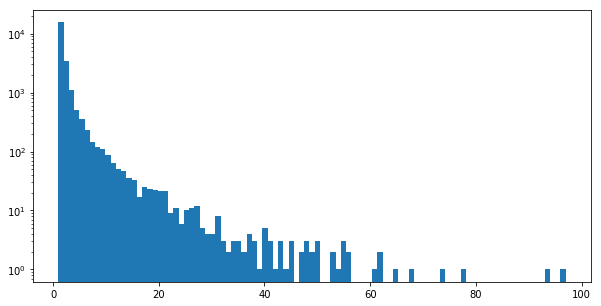

count    22160.000000
mean         2.040298
std          3.641321
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         97.000000
dtype: float64

There are 15530 single-article events and 6630 multiple-article events.


In [41]:
get_infomap_descriptives(H)

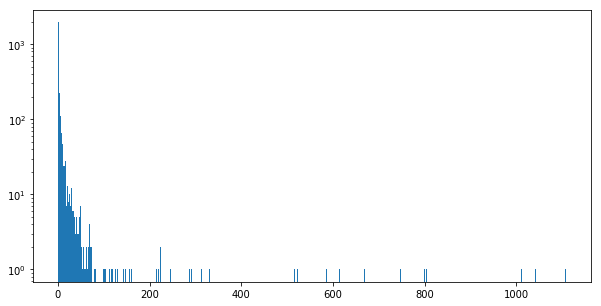

count    3728.000000
mean       12.233906
std        63.510496
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max      1108.000000
dtype: float64

There are 1951 single-article events and 1777 multiple-article events.


In [42]:
get_infomap_descriptives(Hsoft)

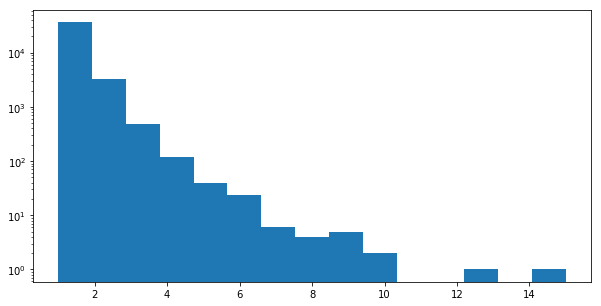

count    40249.000000
mean         1.123332
std          0.447774
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36347 single-article events and 3902 multiple-article events.


In [43]:
get_infomap_descriptives(H06)

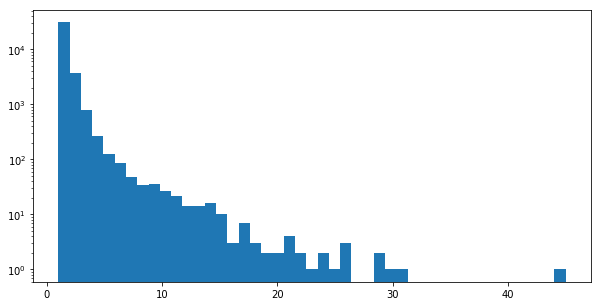

count    35927.000000
mean         1.269463
std          1.126996
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         45.000000
dtype: float64

There are 30700 single-article events and 5227 multiple-article events.


In [44]:
get_infomap_descriptives(Hsoft06)

We see that infomap performs *when used without a threshold* considerably worse than the Leiden algorithms (provided a good threshold): max is too high, mean as well. Large diff between softcosine and cosine.nue
Makes sense though for the "story chains" of Nicholls et al: it's less strict than an event, and it's fine if the story continues with different event.

** if used with threshold, very similar results to our apporach **

# Scratch for further looking into the results of infomap below

## wat we nog zouden kunnen doen: zelfde evaluatie als bij Leiden

In [ ]:
for e in Gnxcos.edges(data=True):
    print(*e)

In [ ]:
G_recoveredlabels = nx.relabel_nodes(Gint, dict(zip(Gint,G)))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
H_labeled = nx.relabel_nodes(H, dict(zip(H,G)))

In [ ]:
nx.draw(H_labeled, with_labels=True)

In [ ]:

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.show()

In [ ]:
G.edges(data=True)